In [1]:
!pip install qiskit[visualization] qiskit-aer rustworkx scipy matplotlib qiskit_algorithms --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.0 MB/s eta 0:00:00


# Node = 5

## depth = 1

In [3]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

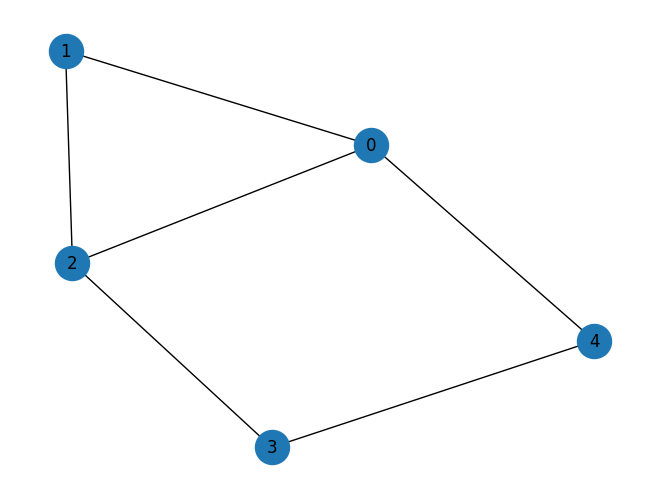

In [4]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [5]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


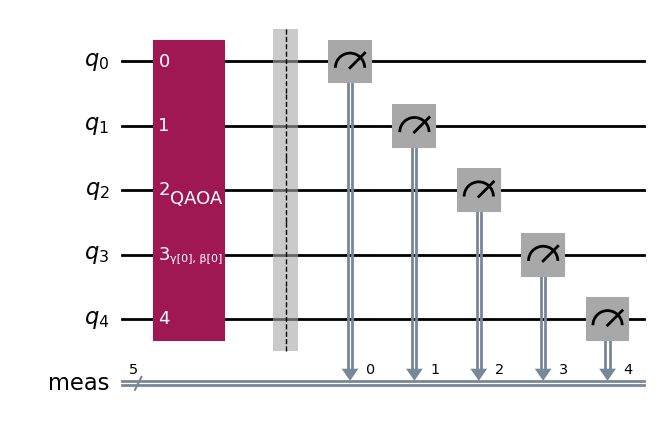

In [6]:
p = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

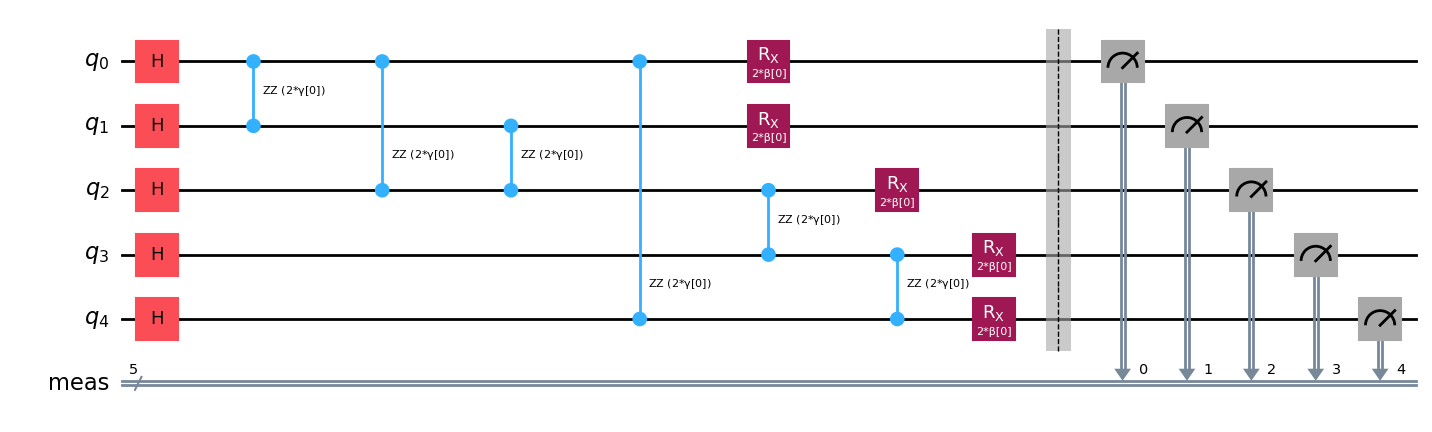

In [7]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [8]:
# Initial params
init_params = [np.pi / 2, np.pi / 2]

# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")
def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633], Cost: 0.083984375
[Noiseless] Params: [2.57079633 1.57079633], Cost: 0.033203125
[Noiseless] Params: [2.57079633 2.57079633], Cost: 1.861328125
[Noiseless] Params: [2.59856339 0.57118191], Cost: -0.666015625
[Noiseless] Params: [ 2.67111607 -0.42618268], Cost: 3.001953125
[Noiseless] Params: [2.63483973 0.07249962], Cost: -0.775390625
[Noiseless] Params: [ 3.11078617 -0.08071587], Cost: 0.08984375
[Noiseless] Params: [ 2.14328489 -0.01900906], Cost: -0.07421875
[Noiseless] Params: [2.88406792 0.05287027], Cost: -0.509765625
[Noiseless] Params: [2.63052576 0.19742515], Cost: -1.51171875
[Noiseless] Params: [2.61775508 0.32177108], Cost: -1.560546875
[Noiseless] Params: [2.55558211 0.31538573], Cost: -1.306640625
[Noiseless] Params: [2.74030782 0.34638459], Cost: -2.1484375
[Noiseless] Params: [2.86316358 0.36943806], Cost: -2.076171875
[Noiseless] Params: [2.72260672 0.40632557], Cost: -1.89453125
[Noiseless] Pa

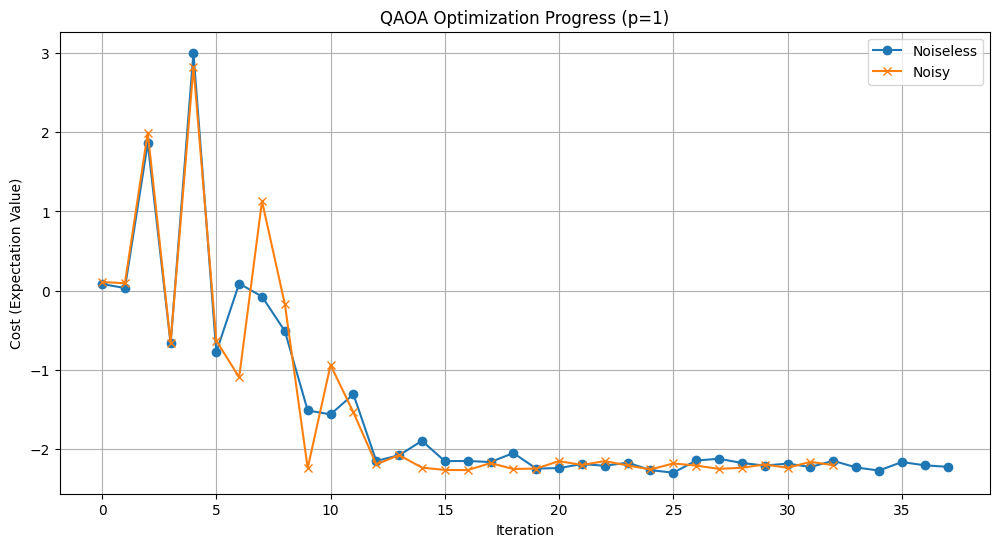

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

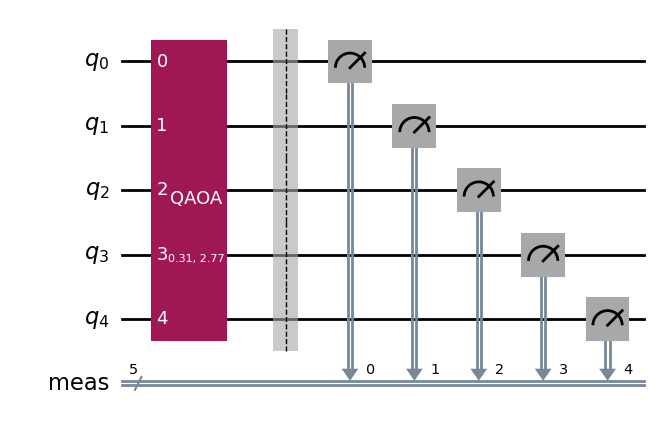

In [10]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

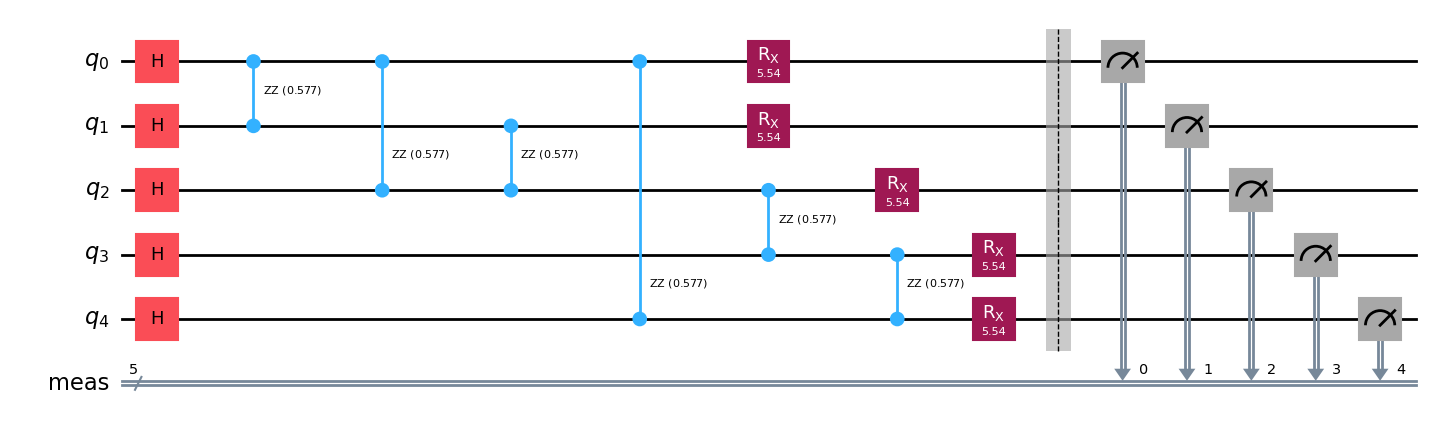

In [11]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [12]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=10000)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [13]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

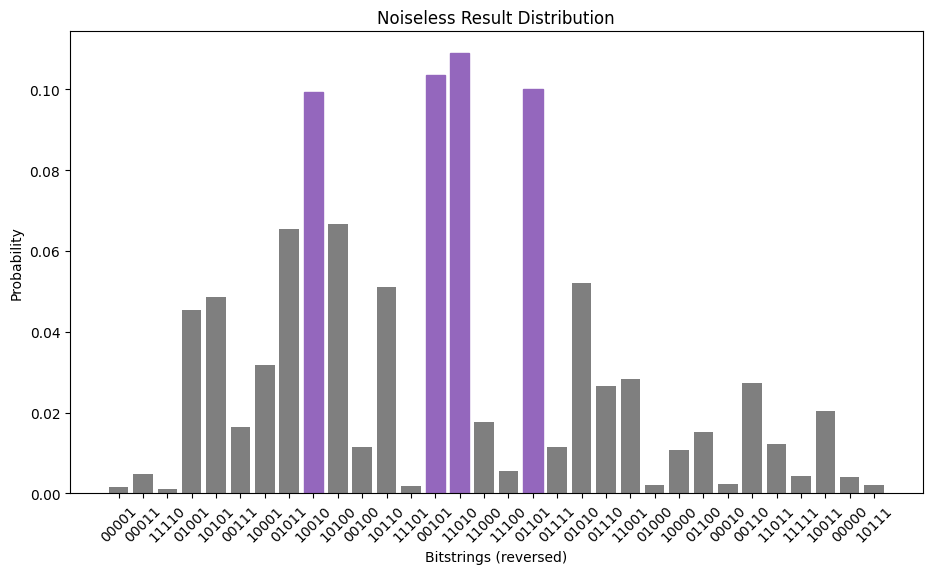

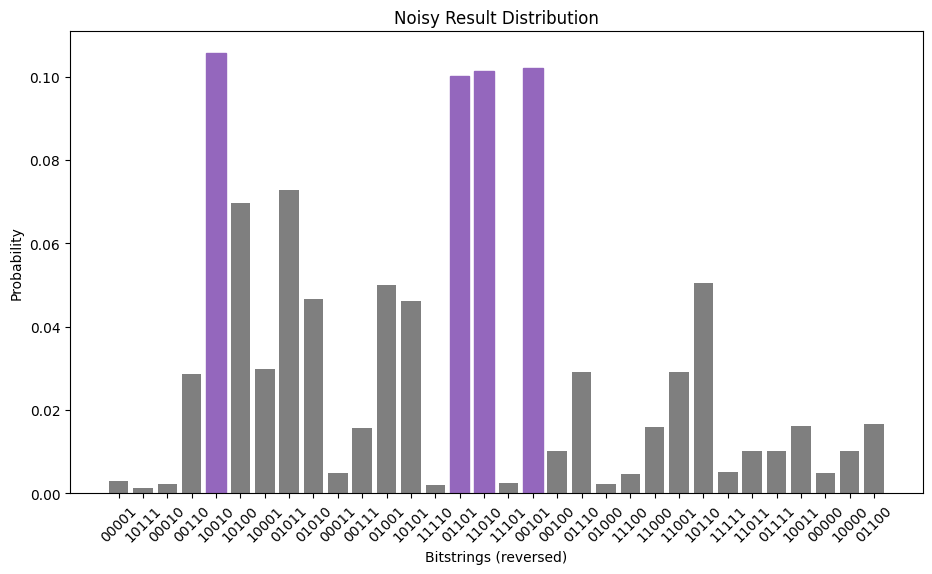

Noiseless bitstring: [1, 1, 0, 1, 0]
Noisy bitstring: [1, 0, 0, 1, 0]


In [14]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 5
Cut value (noisy): 5


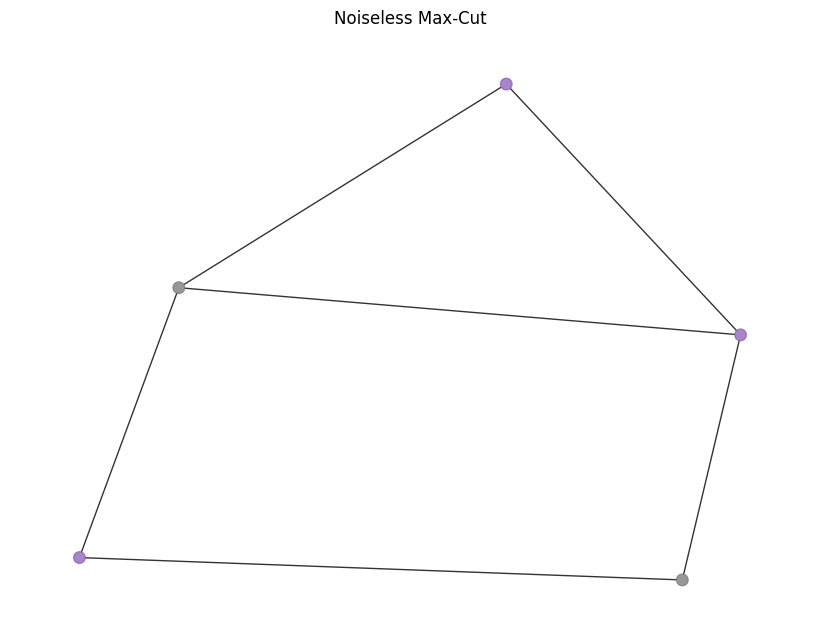

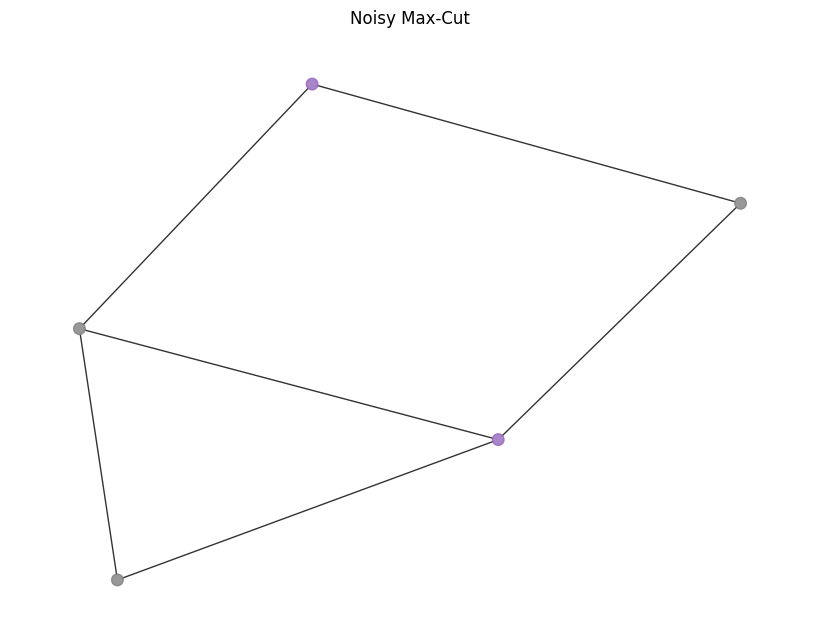

In [15]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

## depth = 2

In [16]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

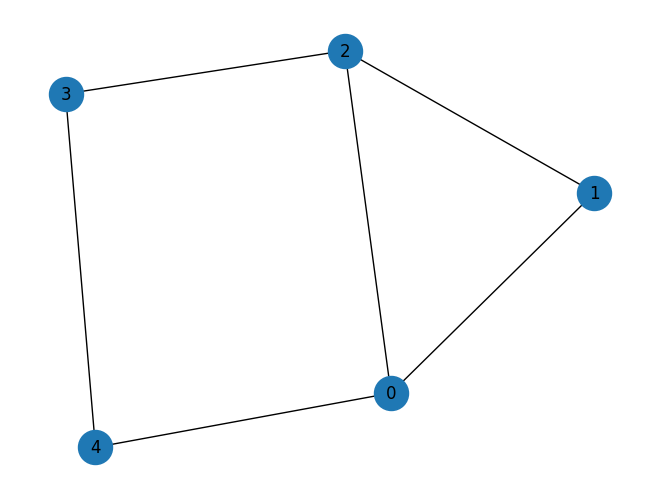

In [17]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [18]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


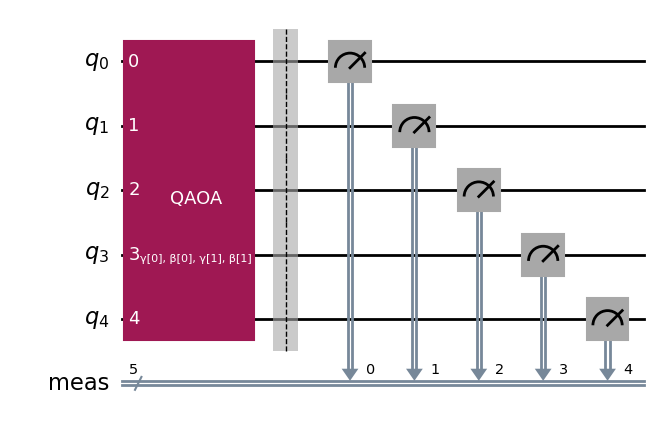

In [19]:
p = 2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

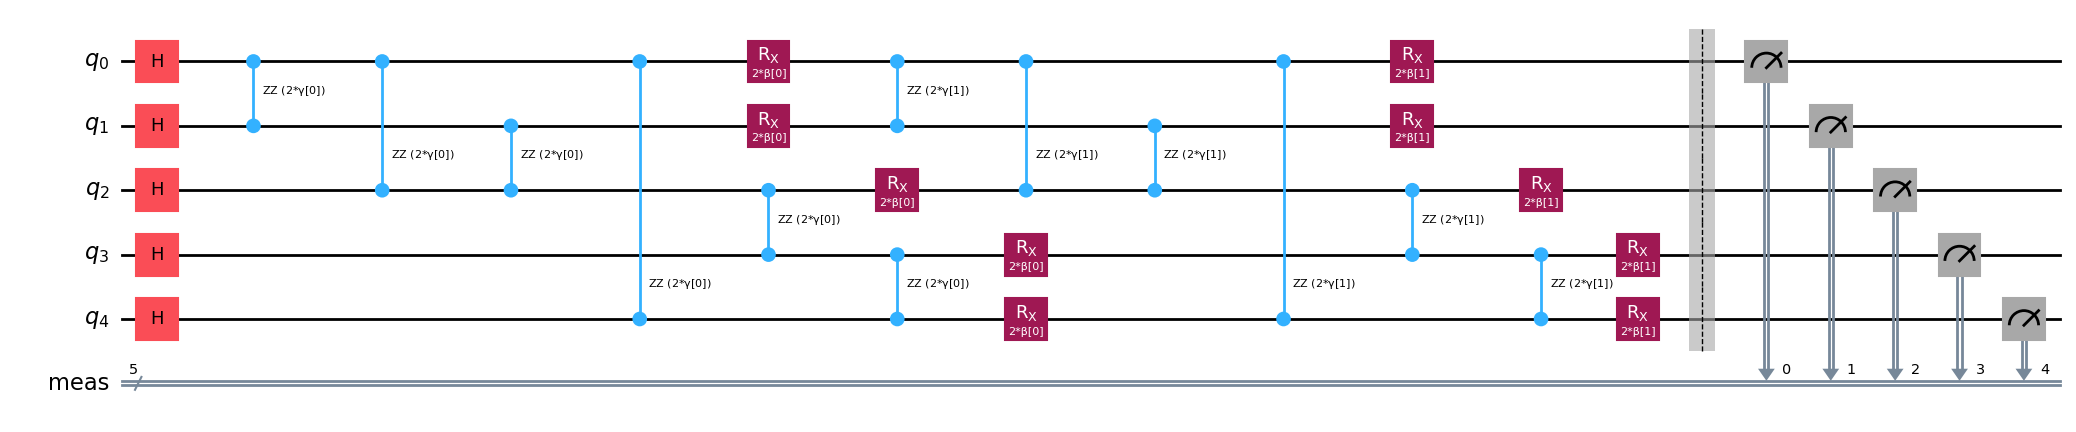

In [20]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [21]:
# Initial params
init_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2]

# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")
def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.056640625
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.072265625
[Noiseless] Params: [2.57079633 2.57079633 1.57079633 1.57079633], Cost: 0.08984375
[Noiseless] Params: [2.57079633 1.57079633 2.57079633 1.57079633], Cost: 2.0703125
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 2.57079633], Cost: -0.216796875
[Noiseless] Params: [2.57805157 1.49552315 0.57592075 2.63790735], Cost: -0.7578125
[Noiseless] Params: [ 2.60569211  1.20875255 -0.34691668  2.89358235], Cost: 3.18359375
[Noiseless] Params: [2.59187184 1.35213785 0.11450203 2.76574485], Cost: 1.09765625
[Noiseless] Params: [2.57805157 1.27114955 0.66401398 2.70421019], Cost: 0.51953125
[Noiseless] Params: [2.57892224 1.92936703 0.72109976 2.83965419], Cost: 0.873046875
[Noiseless] Params: [2.82791306 1.49595189 0.58158735 2.63182931], Cost: -1.373046875
[Noiseless] Params: [2.91219401 1

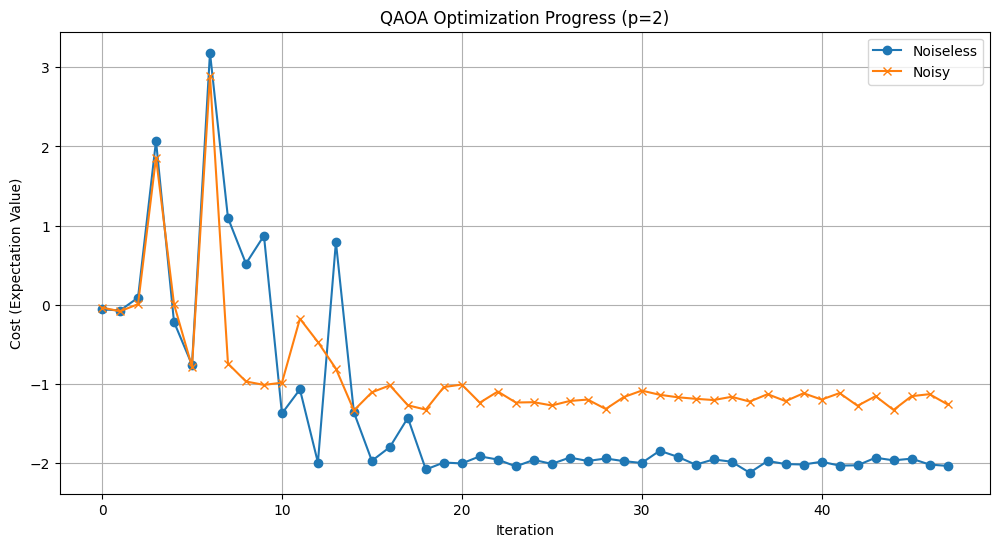

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

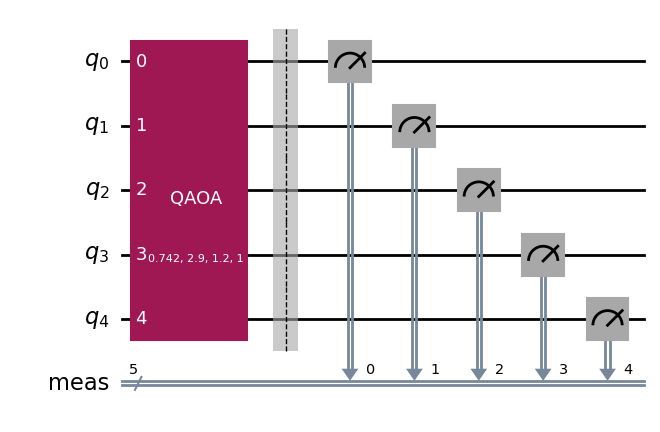

In [23]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

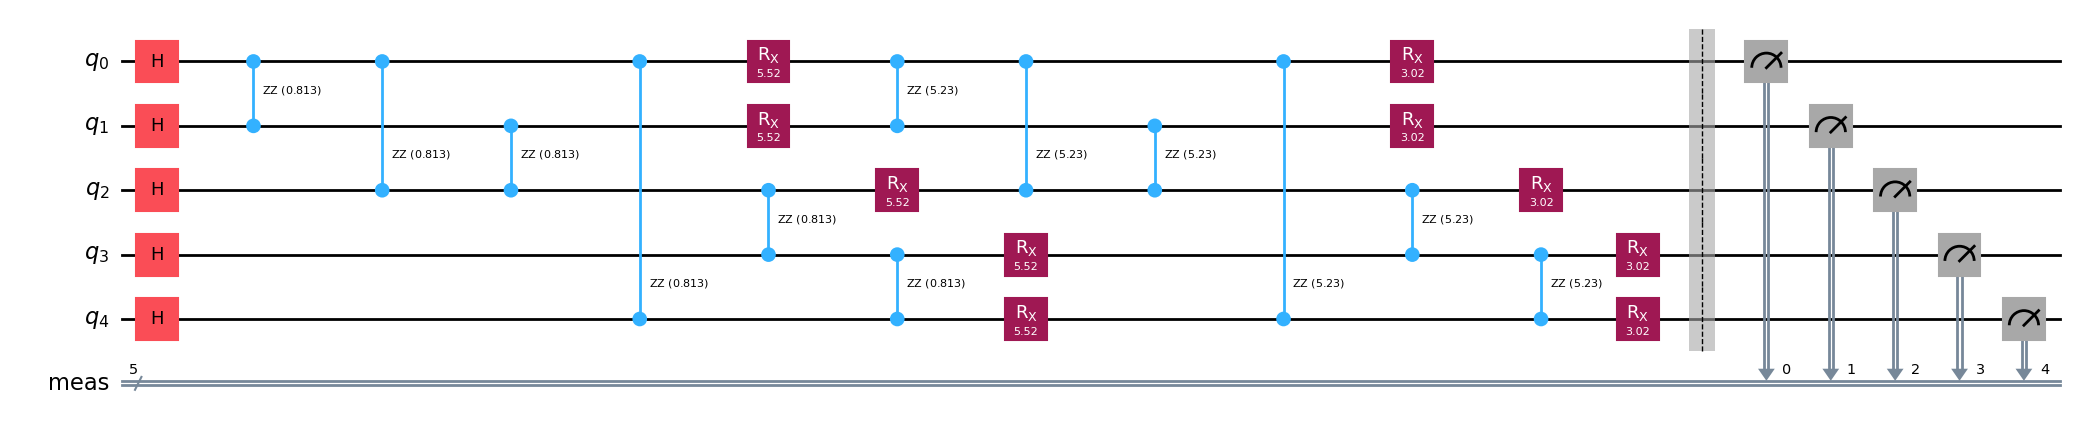

In [24]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [25]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=10000)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [26]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

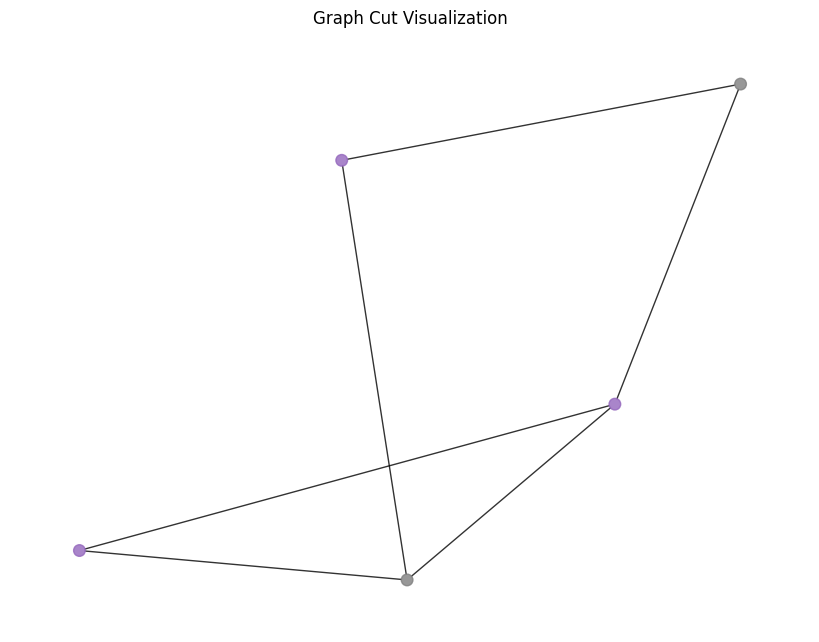

In [27]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

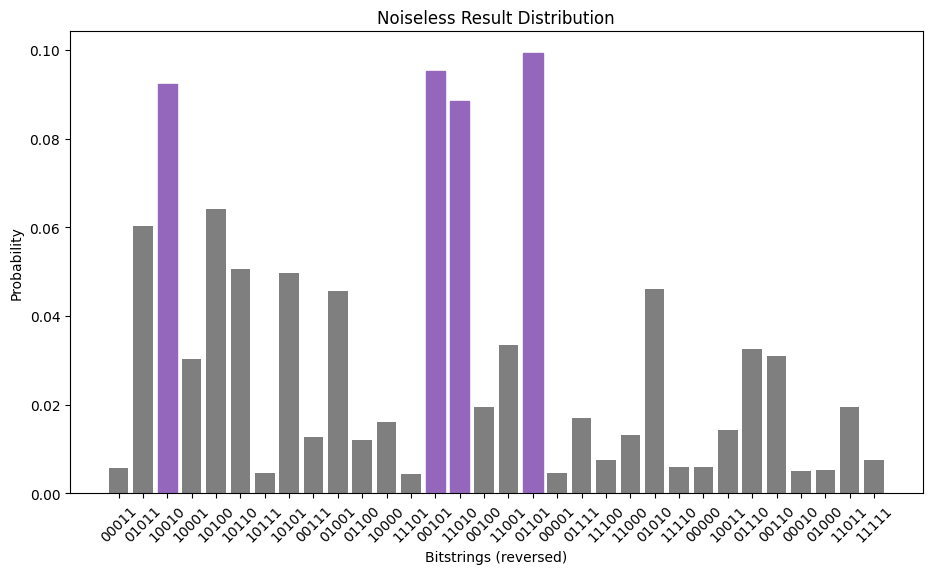

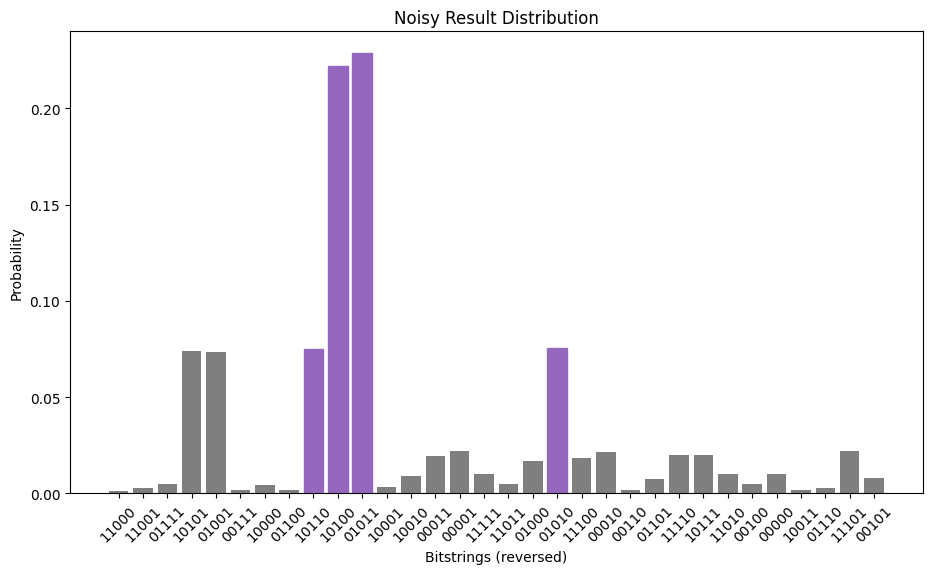

Noiseless bitstring: [0, 1, 1, 0, 1]
Noisy bitstring: [0, 1, 0, 1, 1]


In [28]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 5
Cut value (noisy): 4


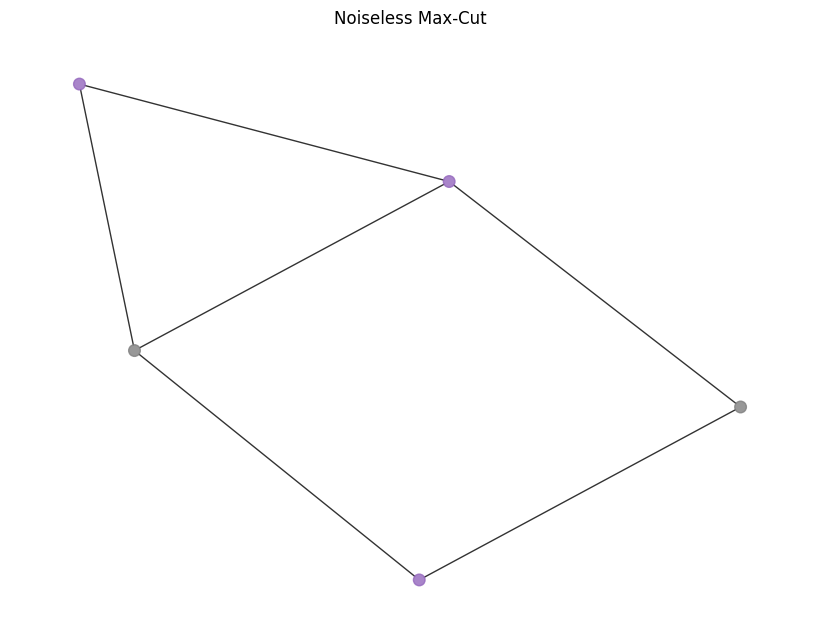

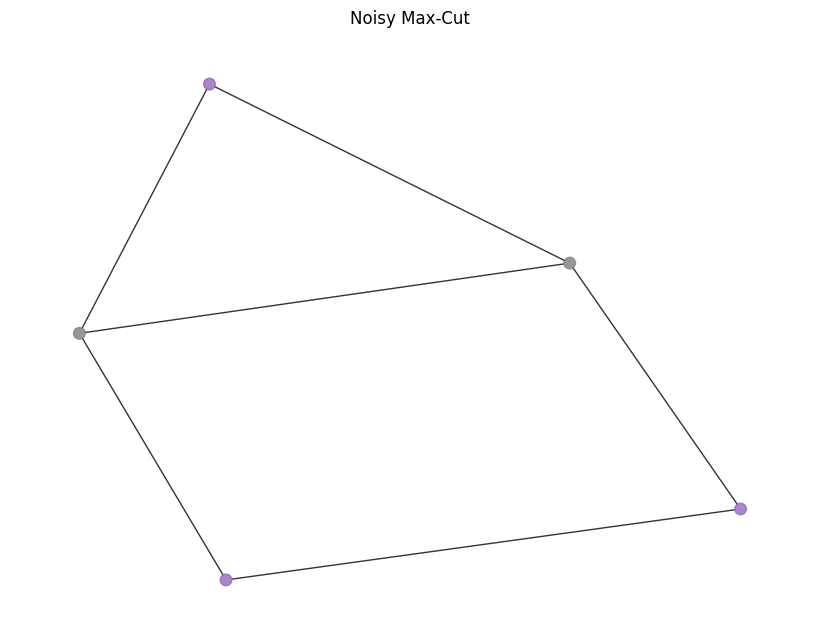

In [29]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

## depth = 3

In [30]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

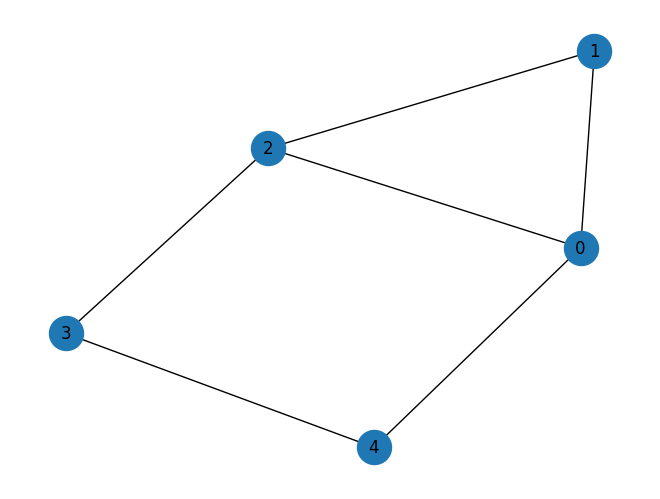

In [31]:
n = 5
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [32]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


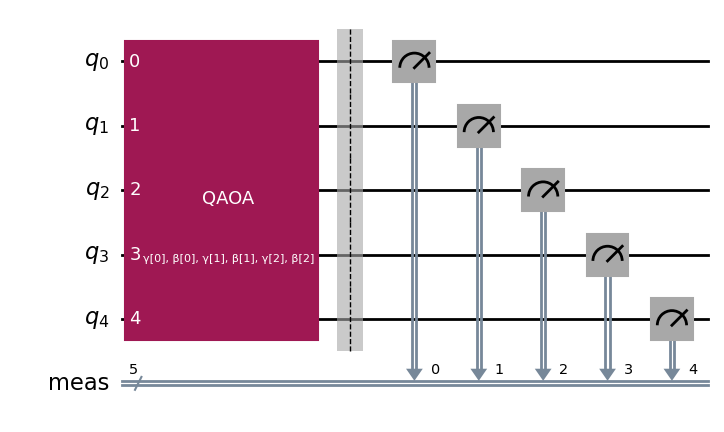

In [33]:
p = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

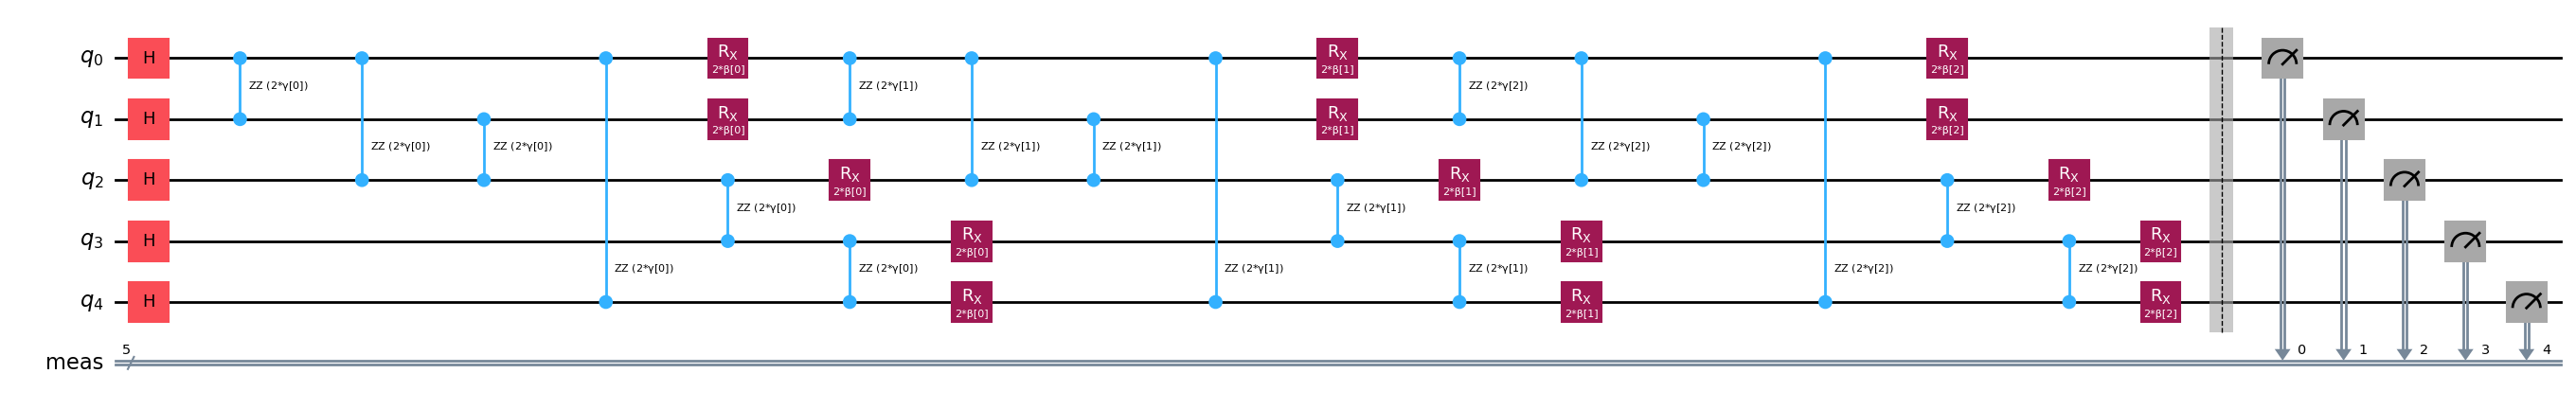

In [34]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [35]:
# Initial params
init_params = [np.pi / 2] * 6
# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.146484375
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.09375
[Noiseless] Params: [2.57079633 2.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.0625
[Noiseless] Params: [2.57079633 2.57079633 2.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.0
[Noiseless] Params: [2.57079633 2.57079633 2.57079633 2.57079633 1.57079633 1.57079633], Cost: -0.462890625
[Noiseless] Params: [2.57079633 2.57079633 2.57079633 2.57079633 2.57079633 1.57079633], Cost: 0.314453125
[Noiseless] Params: [2.57079633 2.57079633 2.57079633 2.57079633 1.57079633 2.57079633], Cost: 0.2578125
[Noiseless] Params: [2.61625686 2.5977359  2.62467548 2.96983882 0.90067434 0.94950232], Cost: 0.849609375
[Noiseless] Params: [2.5935266  2.58426612 2.5977359  2.77031757 1.23573533 1.26014932], Cost: 1.6640625
[Noiseless] Params: [2.820

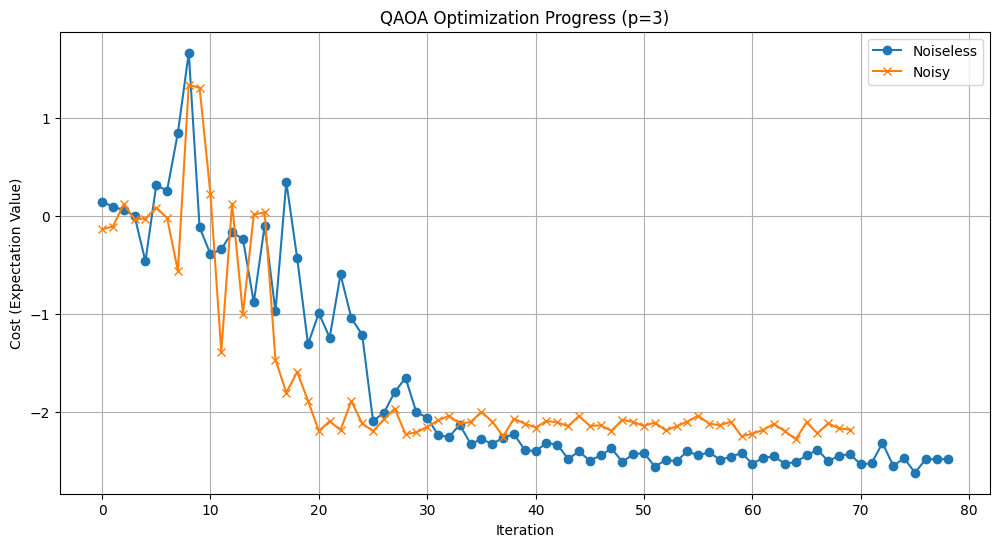

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

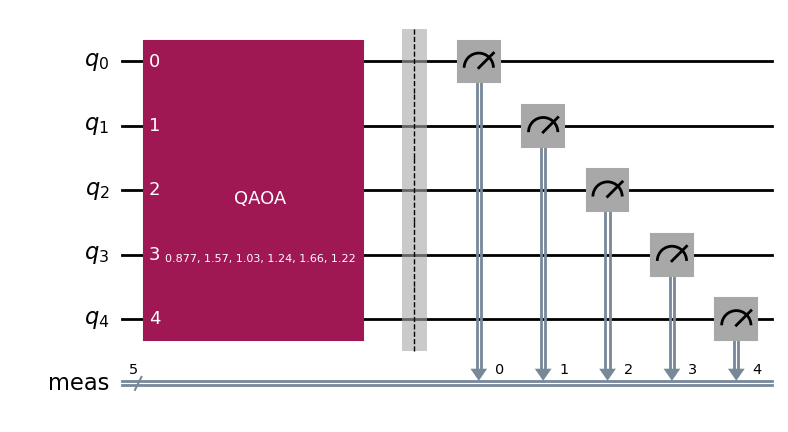

In [37]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

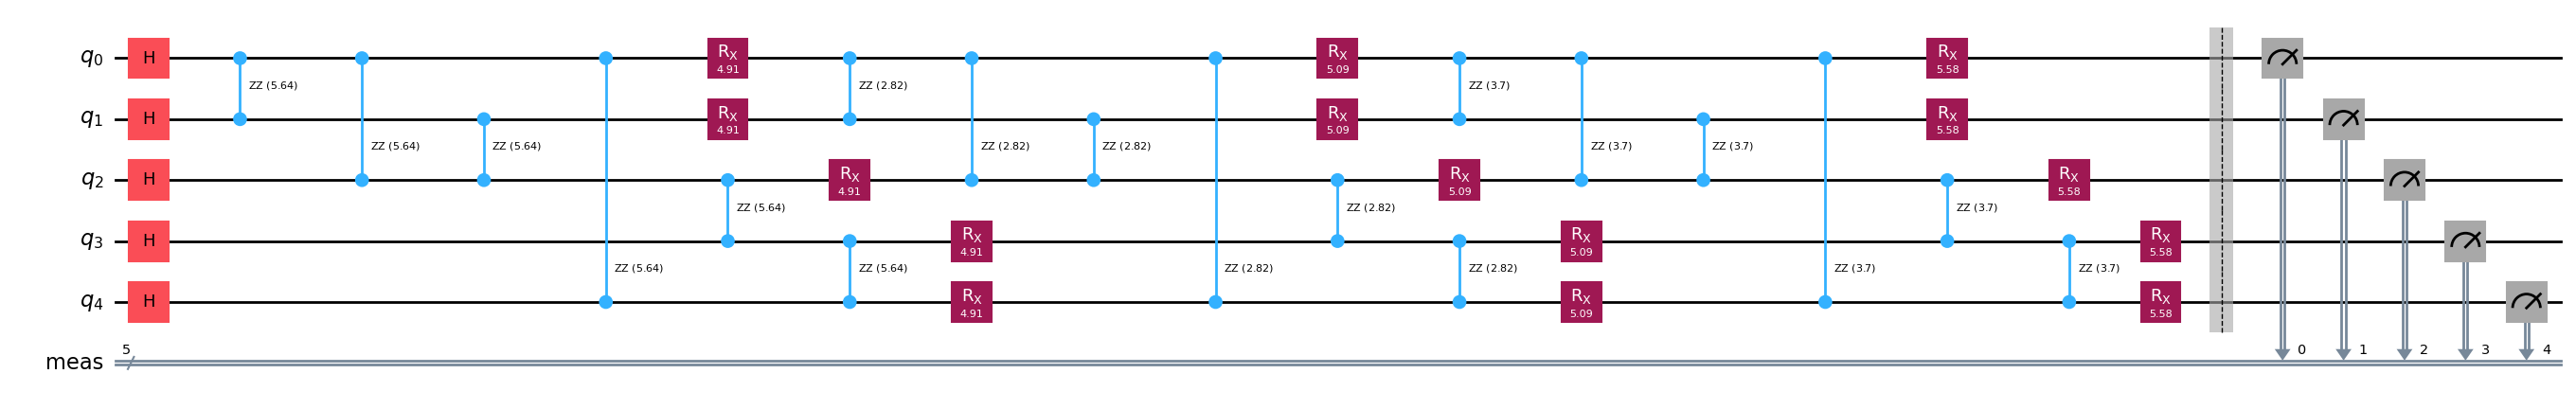

In [38]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [39]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=10000)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [40]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

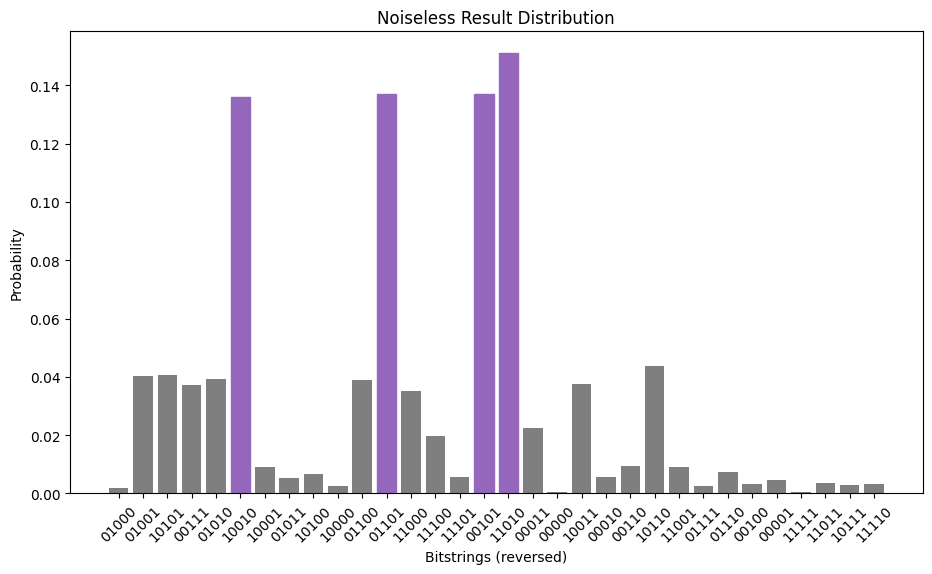

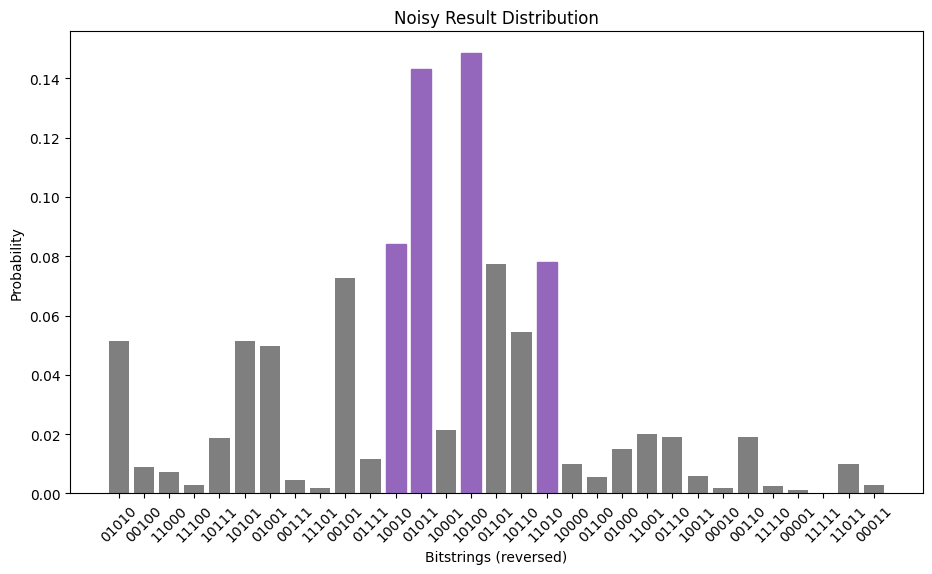

Noiseless bitstring: [1, 1, 0, 1, 0]
Noisy bitstring: [1, 0, 1, 0, 0]


In [41]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 5
Cut value (noisy): 4


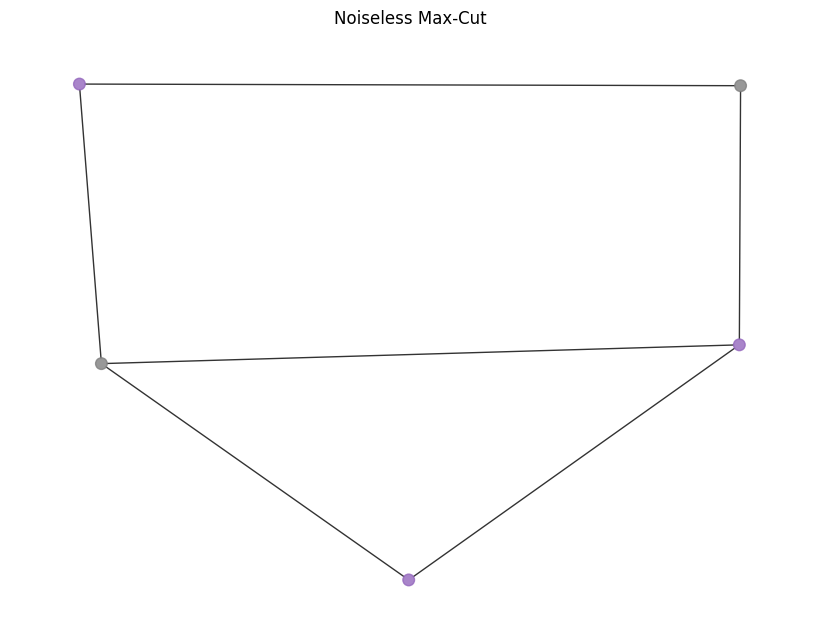

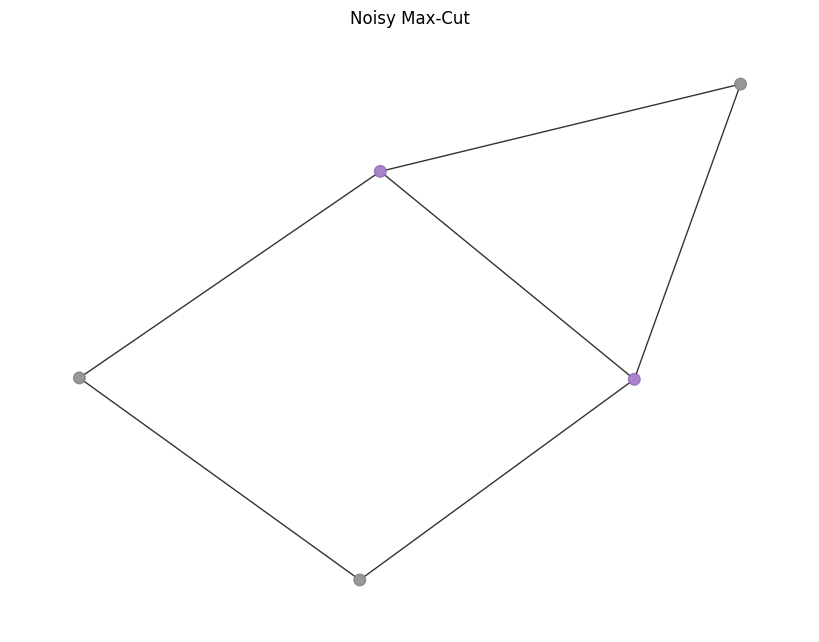

In [42]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

# Node 10

## depth = 1

In [43]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

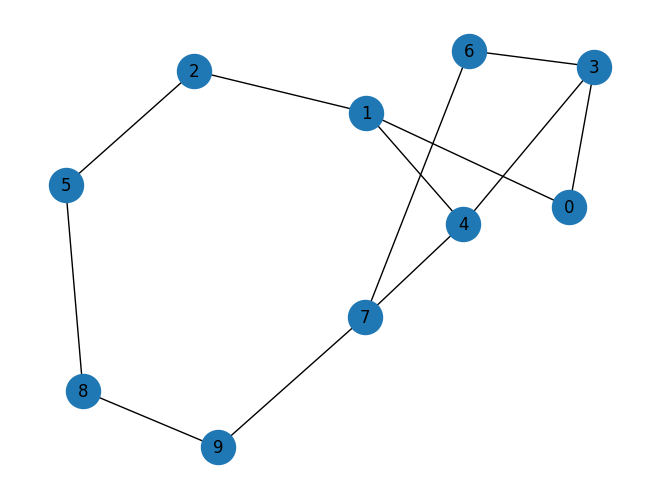

In [44]:
n = 10
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (2, 5, 1.0),
    (3, 4, 1.0),
    (3, 6, 1.0),
    (4, 7, 1.0),
    (5, 8, 1.0),
    (6, 7, 1.0),
    (7, 9, 1.0),
    (8, 9, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [45]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIZIIZI', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIZIIZIII', 'IIZIIZIIII', 'IZIIZIIIII', 'IIZZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


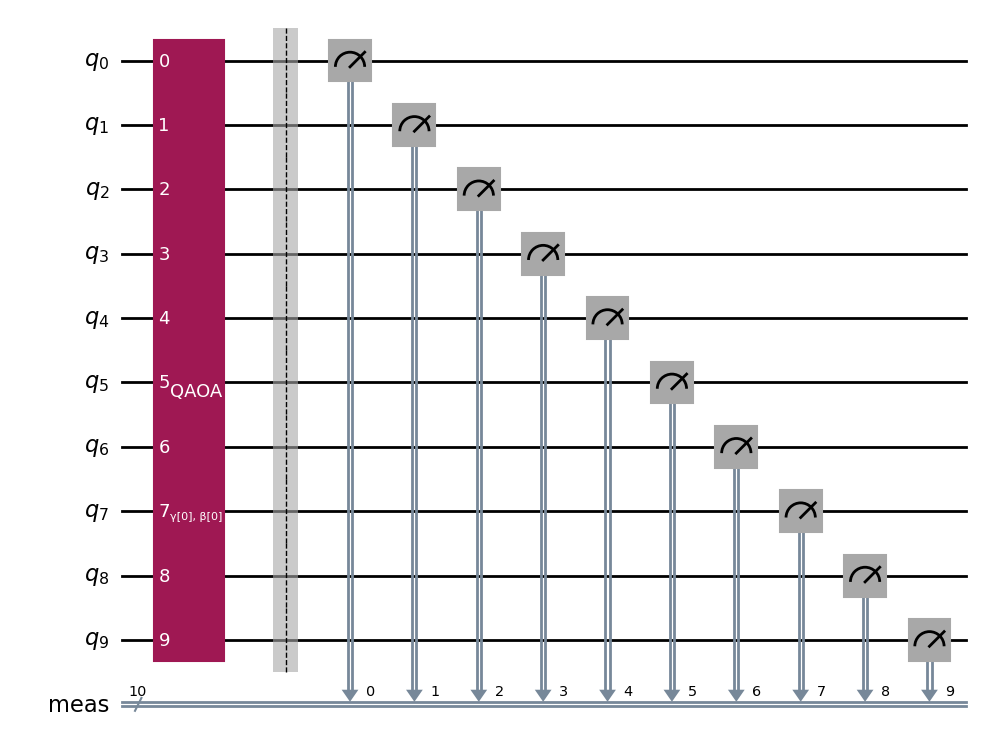

In [46]:
p = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

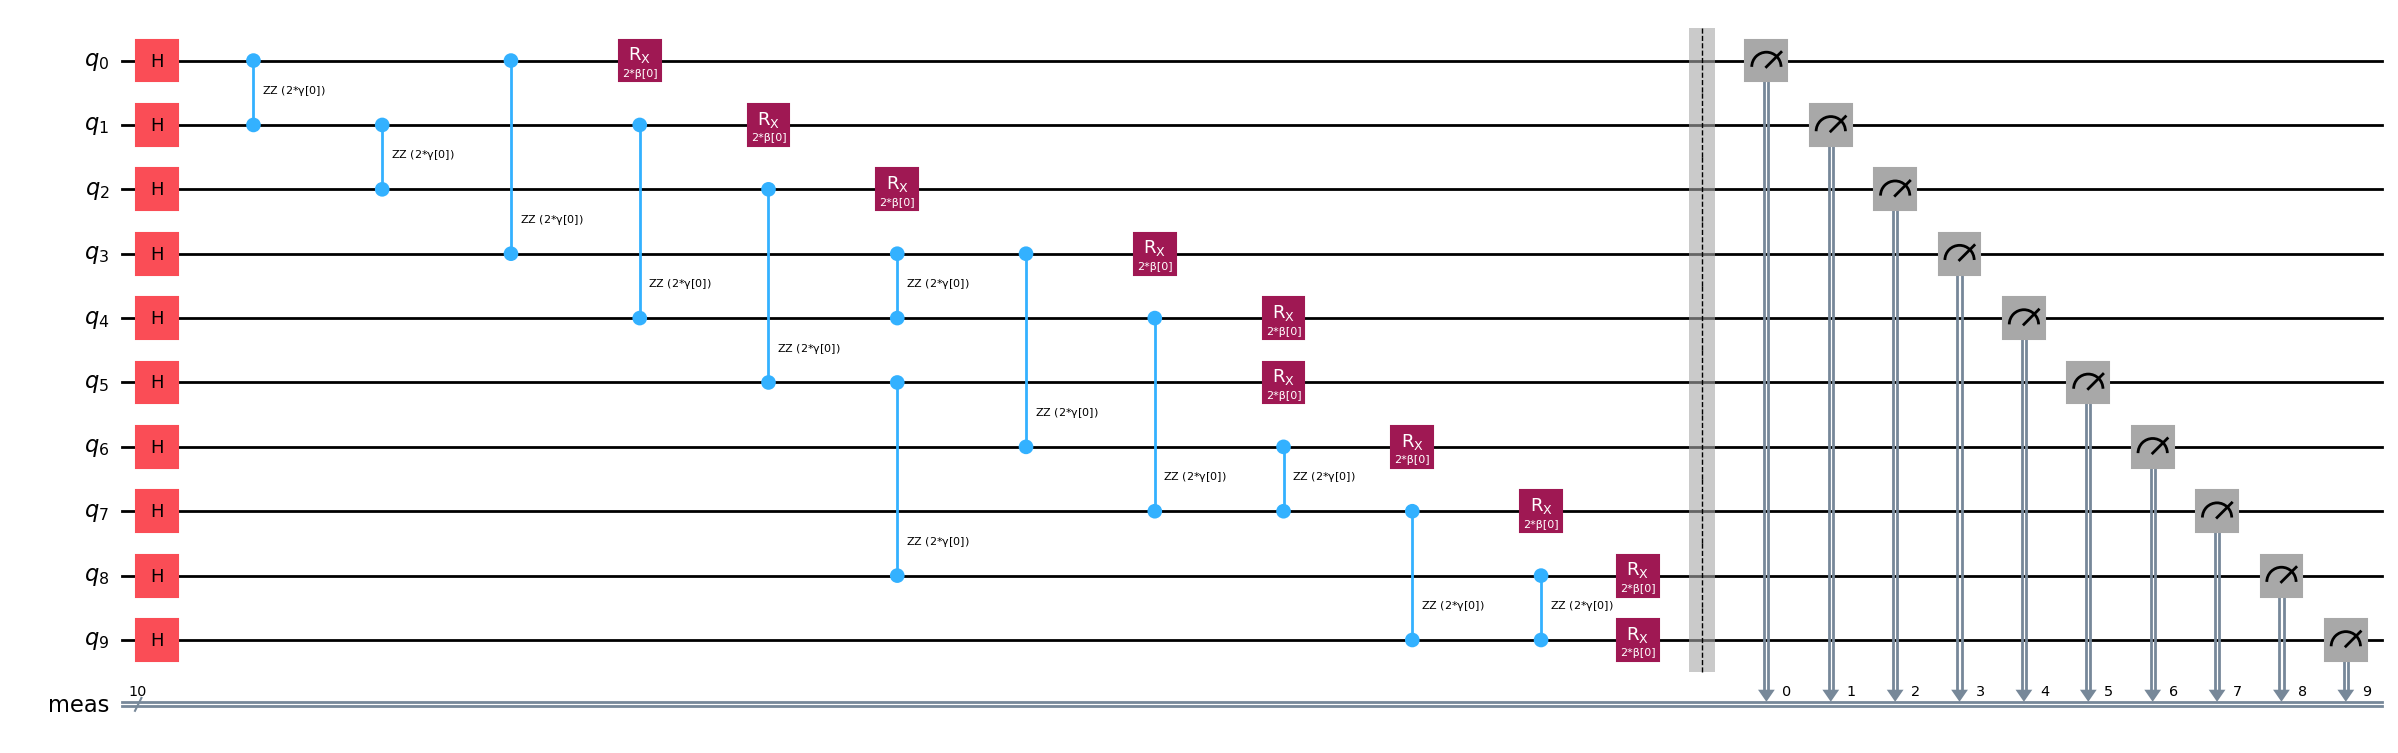

In [47]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [48]:
# Initial params
init_params = [np.pi / 2, np.pi / 2]

# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633], Cost: 0.123046875
[Noiseless] Params: [2.57079633 1.57079633], Cost: 0.0078125
[Noiseless] Params: [2.57079633 2.57079633], Cost: 2.470703125
[Noiseless] Params: [2.61753346 0.5718891 ], Cost: -2.759765625
[Noiseless] Params: [ 2.65917018 -0.42724371], Cost: 4.62109375
[Noiseless] Params: [3.01461444 0.87574219], Cost: 0.603515625
[Noiseless] Params: [2.16997635 0.79480755], Cost: -0.20703125
[Noiseless] Params: [2.62010575 0.32190234], Cost: -4.4375
[Noiseless] Params: [2.70371943 0.08629938], Cost: -2.1796875
[Noiseless] Params: [2.37295287 0.28427985], Cost: -0.369140625
[Noiseless] Params: [2.73717776 0.27809429], Cost: -4.841796875
[Noiseless] Params: [2.75464417 0.1543206 ], Cost: -3.52734375
[Noiseless] Params: [2.80666126 0.3820031 ], Cost: -5.11328125
[Noiseless] Params: [2.9313692  0.39054302], Cost: -3.775390625
[Noiseless] Params: [2.76014229 0.4237432 ], Cost: -4.94140625
[Noiseless] Params: [2.789

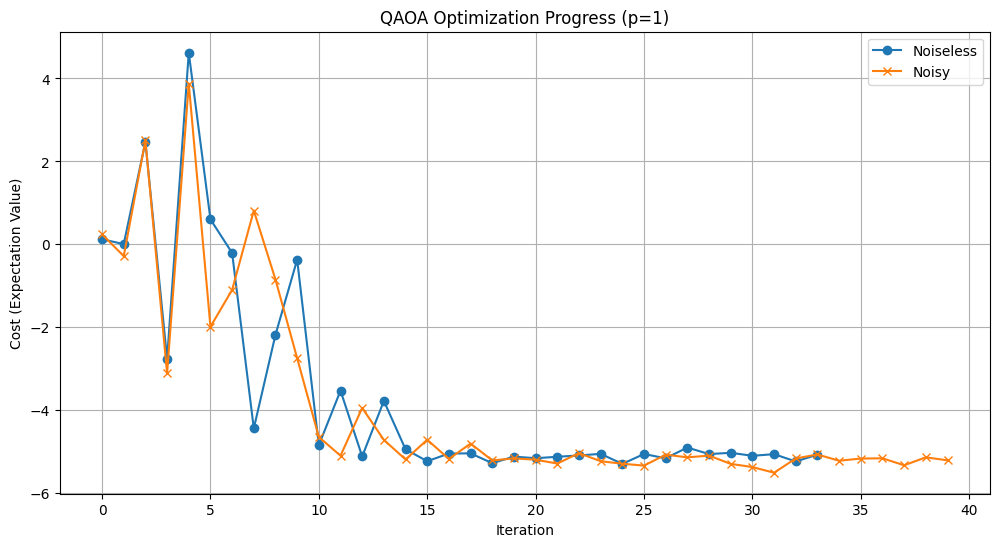

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

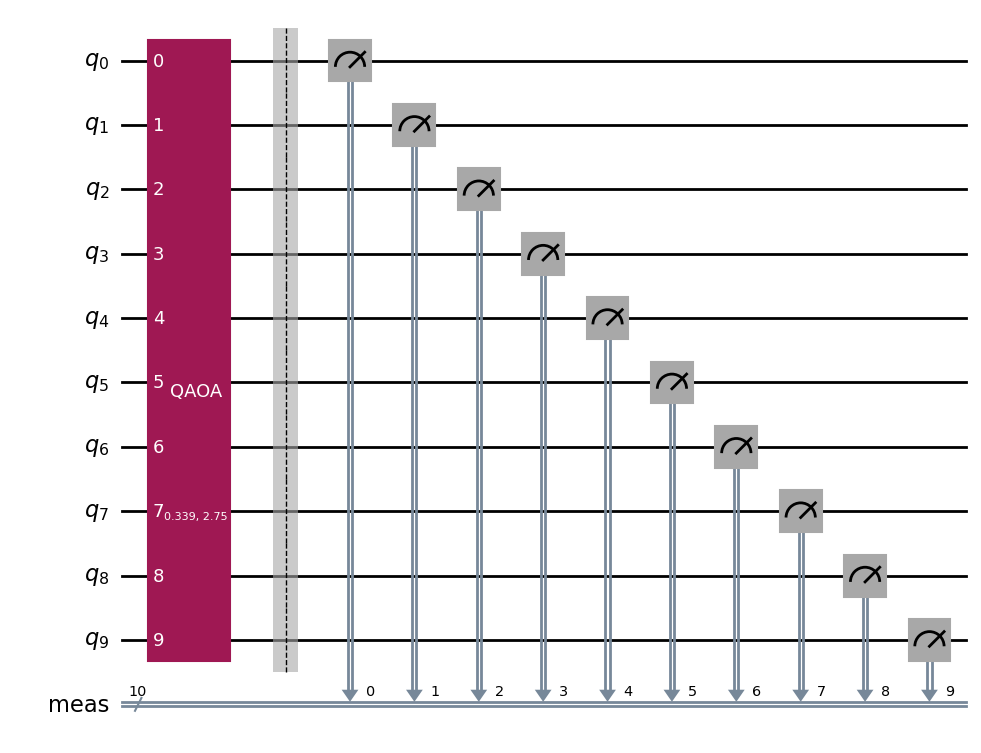

In [50]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

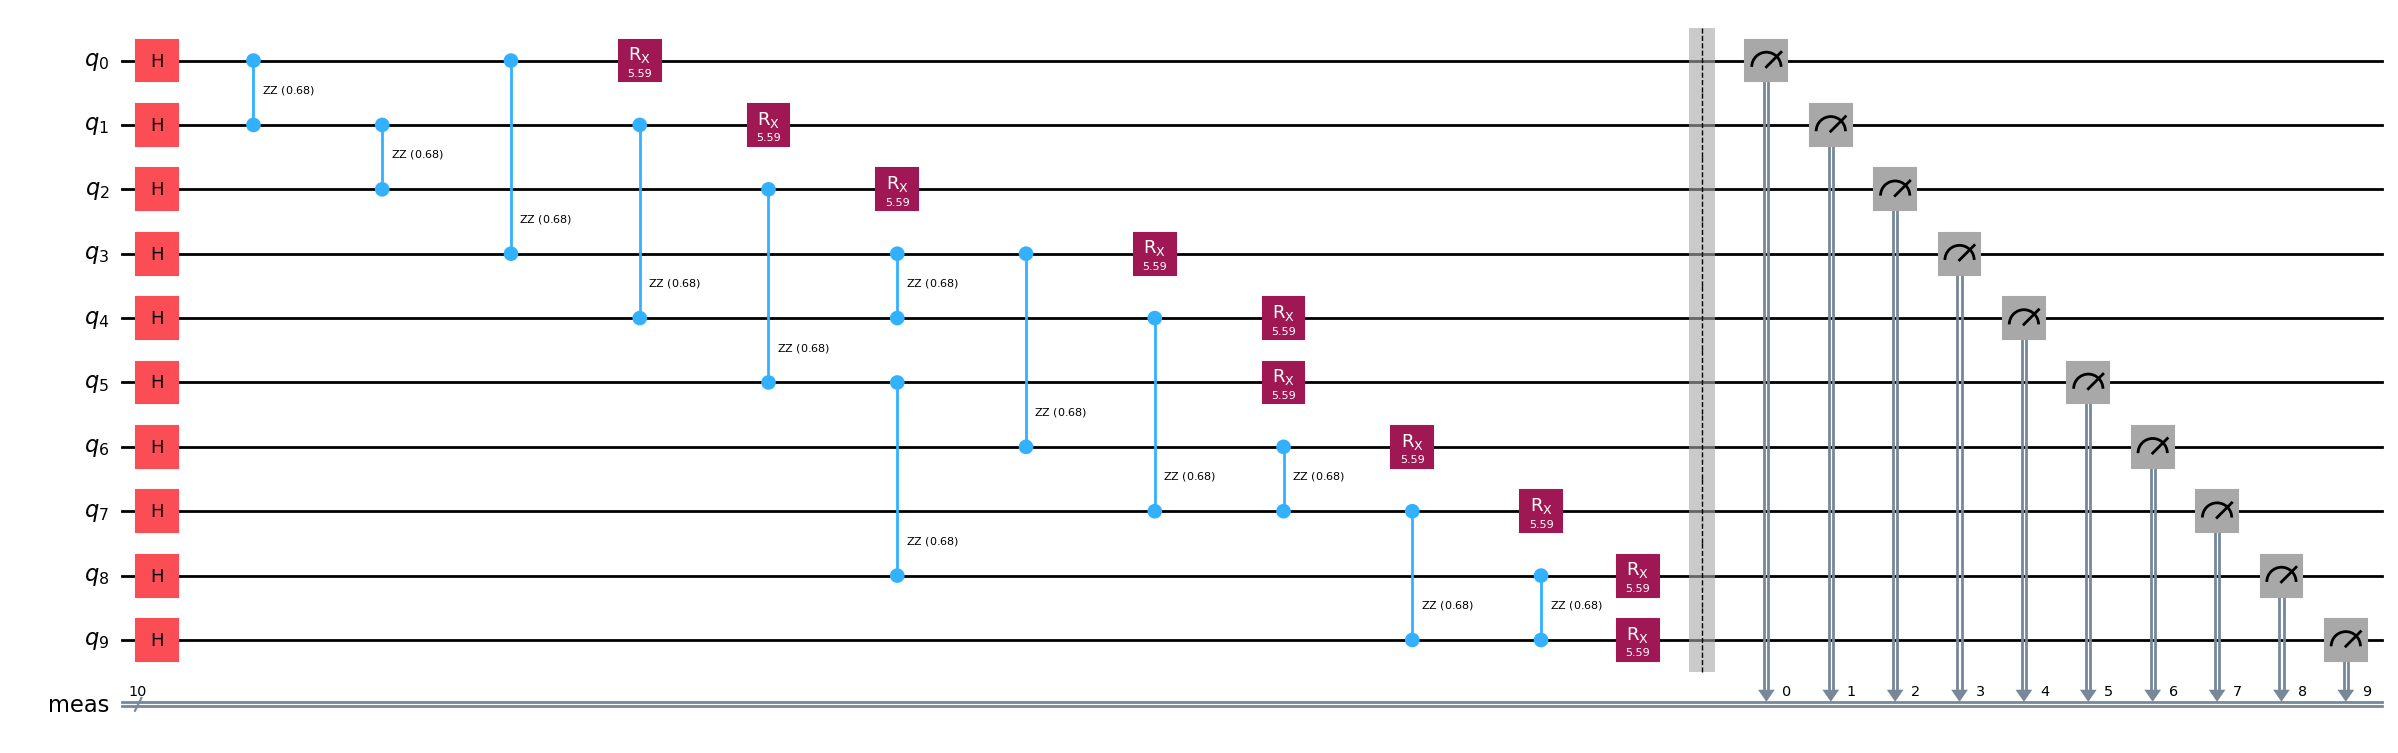

In [51]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [52]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=10000)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [53]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

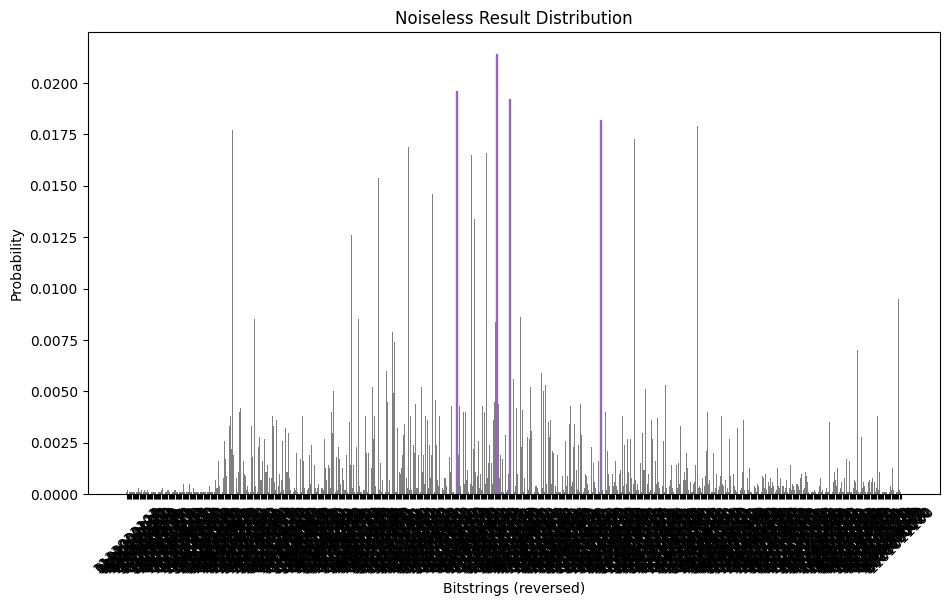

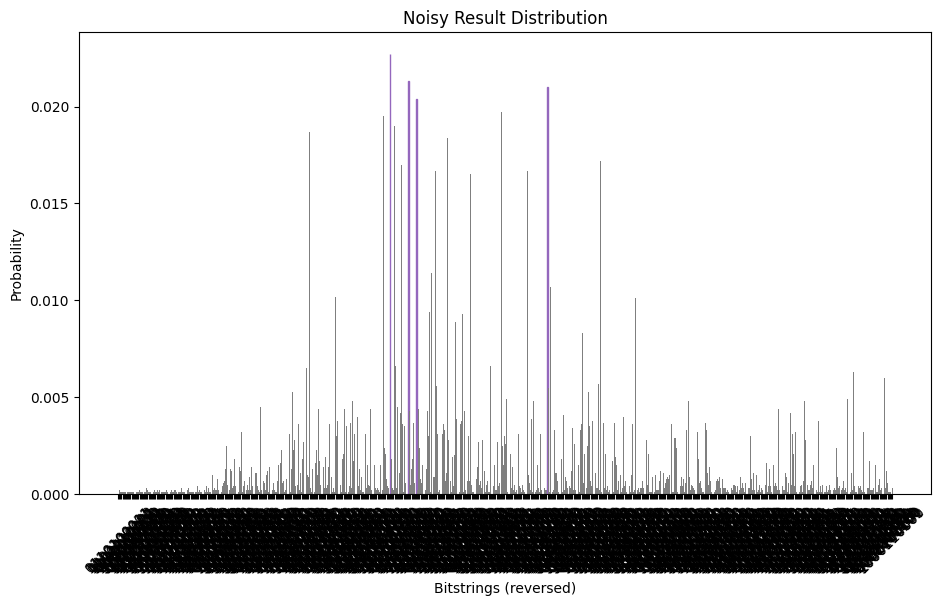

Noiseless bitstring: [1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Noisy bitstring: [1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


In [54]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 11
Cut value (noisy): 11


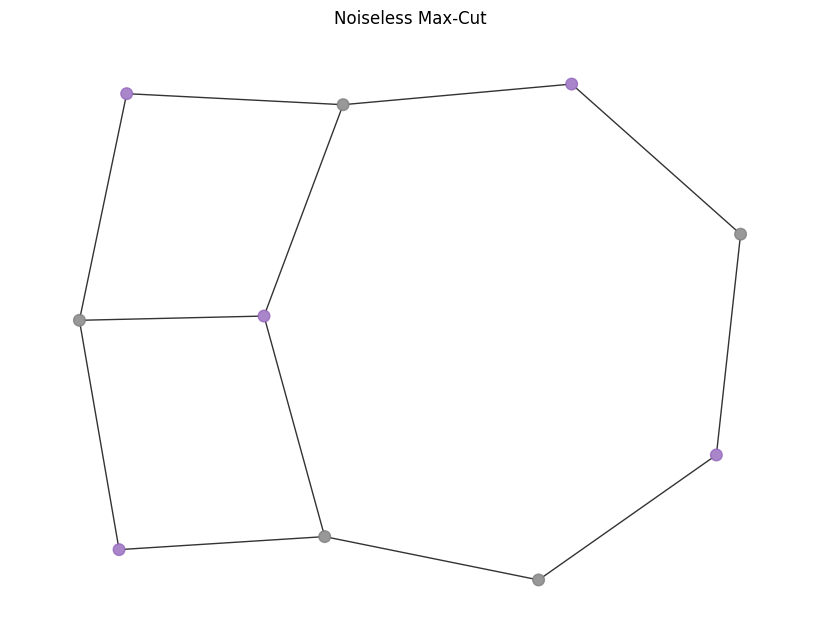

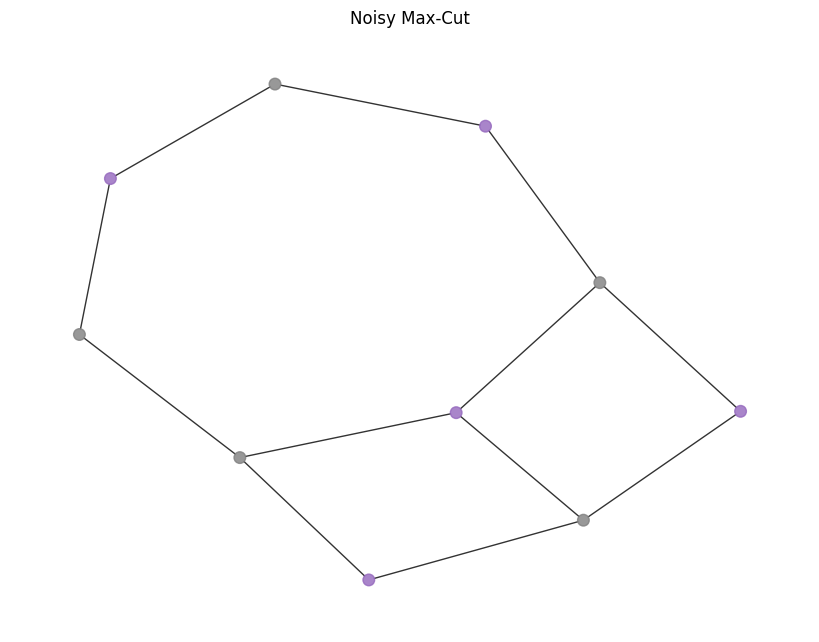

In [55]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

## depth = 2

In [56]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

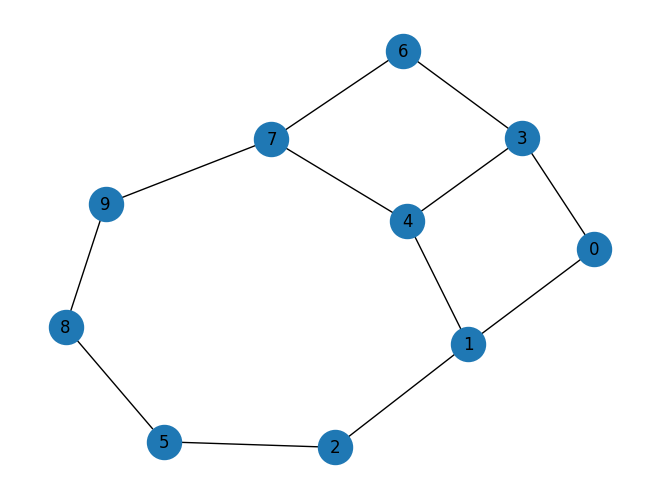

In [57]:
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

n = 10
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (2, 5, 1.0),
    (3, 4, 1.0),
    (3, 6, 1.0),
    (4, 7, 1.0),
    (5, 8, 1.0),
    (6, 7, 1.0),
    (7, 9, 1.0),
    (8, 9, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [58]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIZIIZI', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIZIIZIII', 'IIZIIZIIII', 'IZIIZIIIII', 'IIZZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


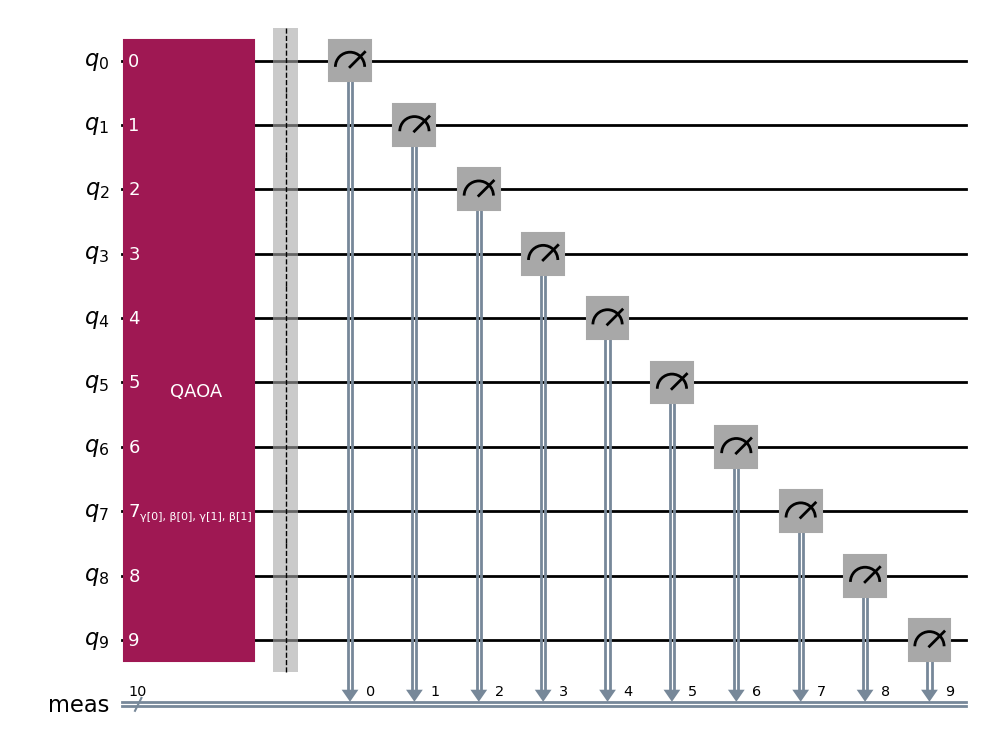

In [59]:
p = 2
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

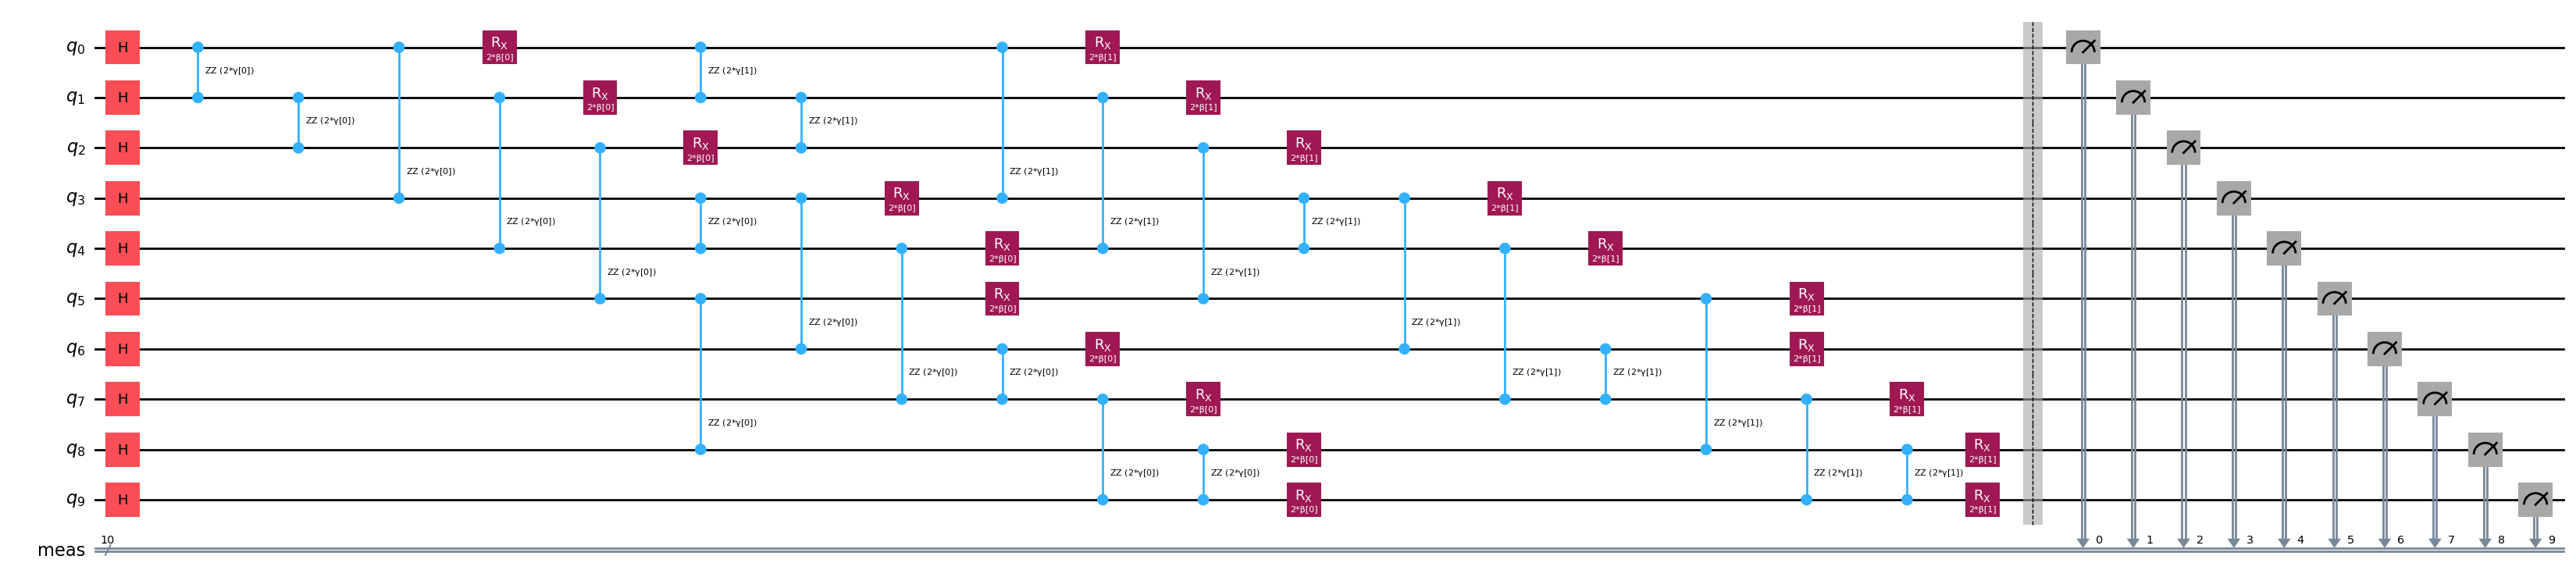

In [60]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [61]:
# Initial params
init_params = [np.pi / 2, np.pi / 2, np.pi / 2, np.pi / 2]

# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.04296875
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.2109375
[Noiseless] Params: [2.57079633 2.57079633 1.57079633 1.57079633], Cost: -0.00390625
[Noiseless] Params: [2.57079633 1.57079633 2.57079633 1.57079633], Cost: 2.3046875
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 2.57079633], Cost: -0.001953125
[Noiseless] Params: [2.63696926 1.48923433 0.57974117 1.48846488], Cost: -2.81640625
[Noiseless] Params: [ 2.70143664  1.40977454 -0.41177108  1.40825547], Cost: 4.888671875
[Noiseless] Params: [2.88815897 1.23710224 0.82415637 1.23628567], Cost: -0.95703125
[Noiseless] Params: [2.63697251 1.31238386 0.57961962 1.66516773], Cost: -2.4375
[Noiseless] Params: [2.88555467 1.80009029 0.73374623 1.74895732], Cost: -1.447265625
[Noiseless] Params: [2.20571885 1.56096583 0.82235189 1.4842565 ], Cost: -0.15234375
[Noiseless] Params: [2.6629887  1.5

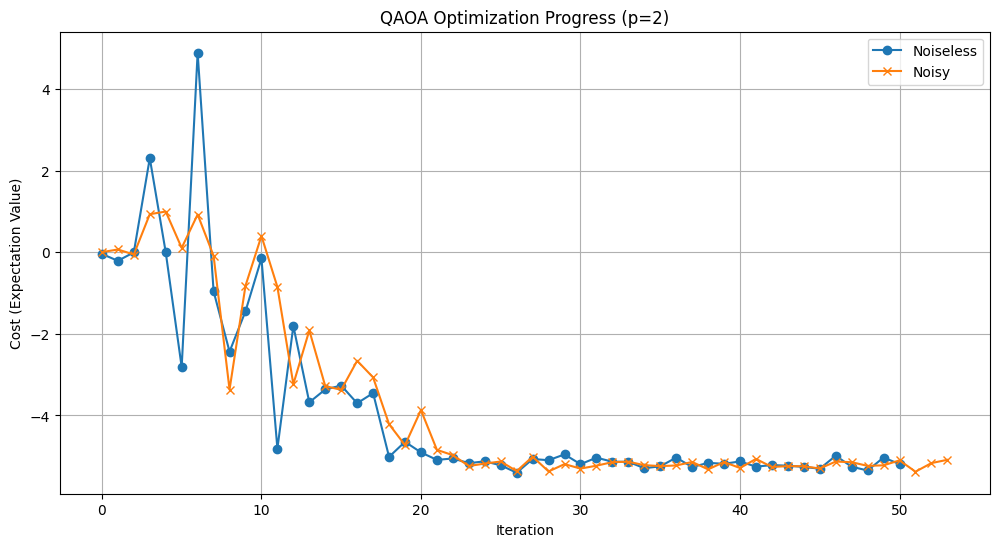

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

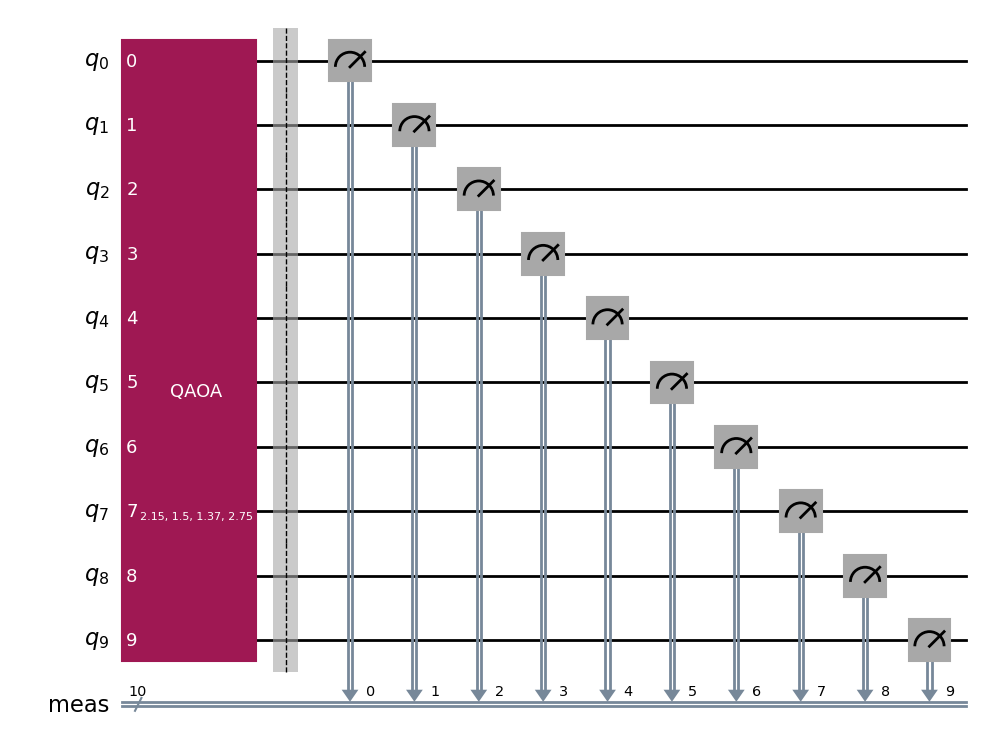

In [63]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

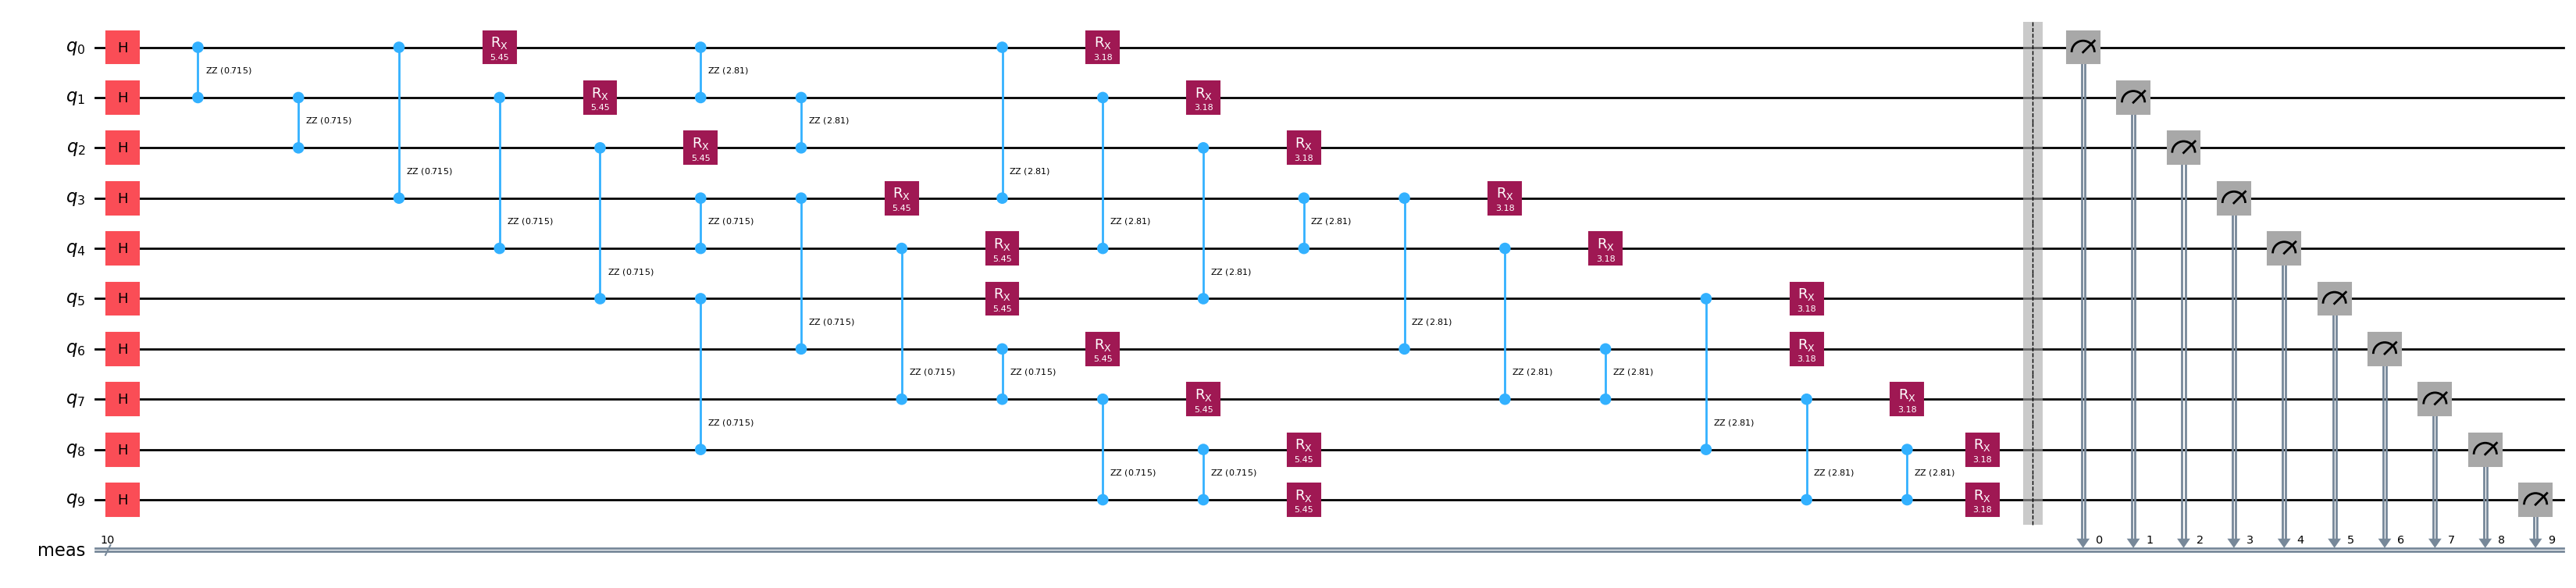

In [64]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [65]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=10000)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [66]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

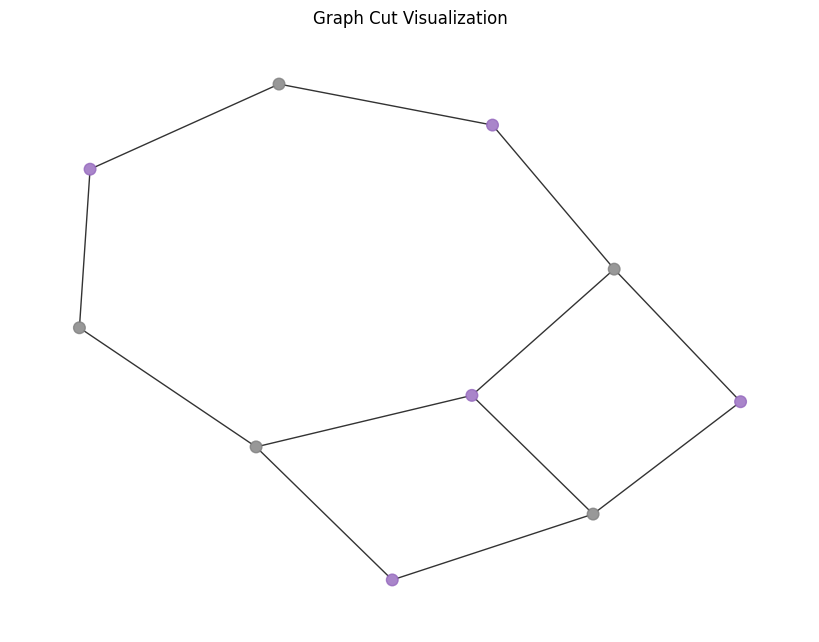

In [67]:
def plot_result(G: rx.PyGraph, x: Sequence[int]):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title("Graph Cut Visualization")
    plt.show()

plot_result(graph, most_likely_bitstring)

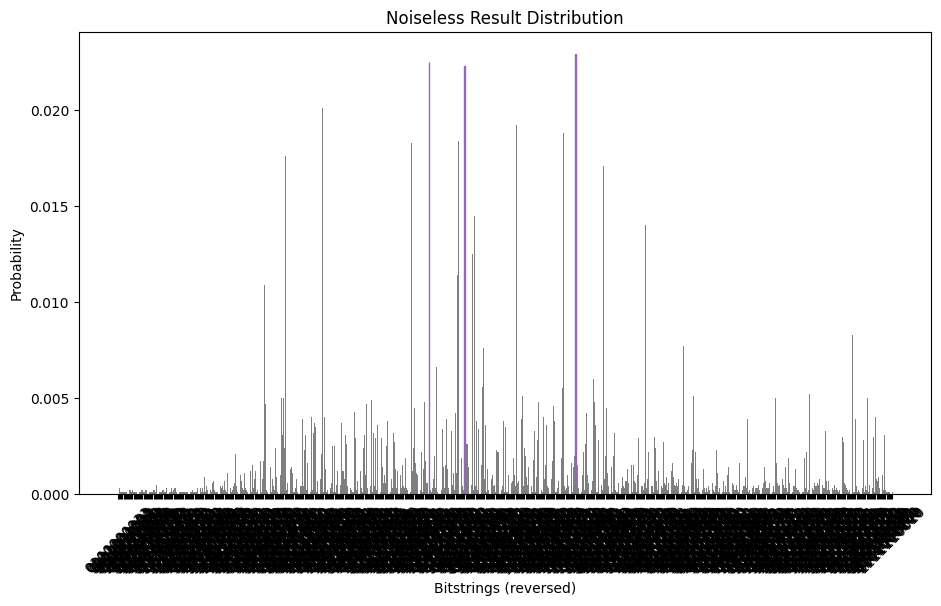

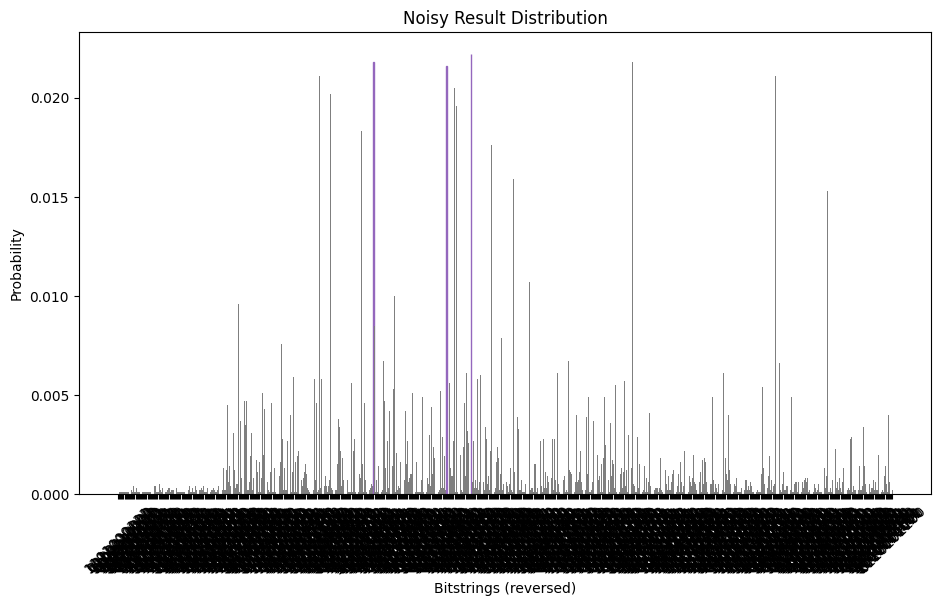

Noiseless bitstring: [1, 0, 0, 0, 1, 1, 1, 0, 0, 1]
Noisy bitstring: [0, 1, 0, 1, 0, 1, 0, 1, 0, 0]


In [68]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 11
Cut value (noisy): 11


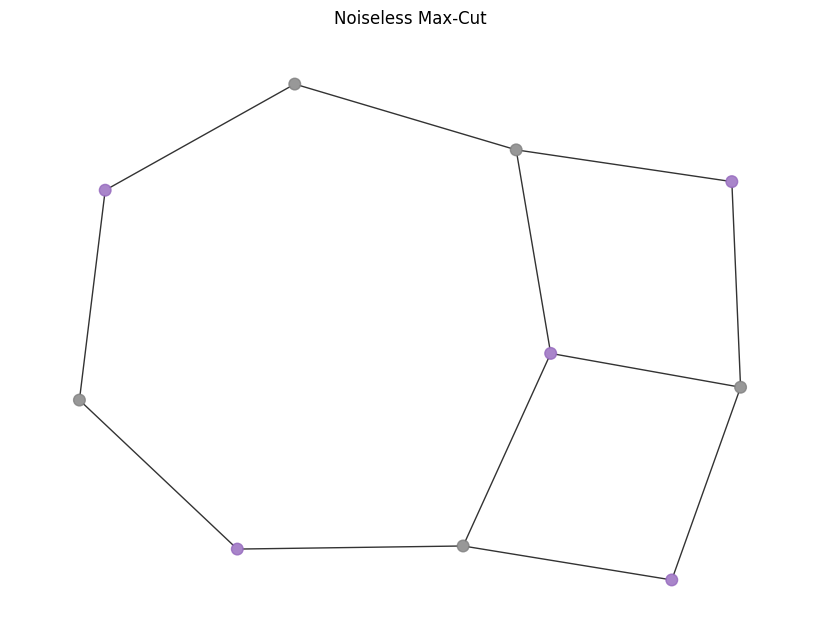

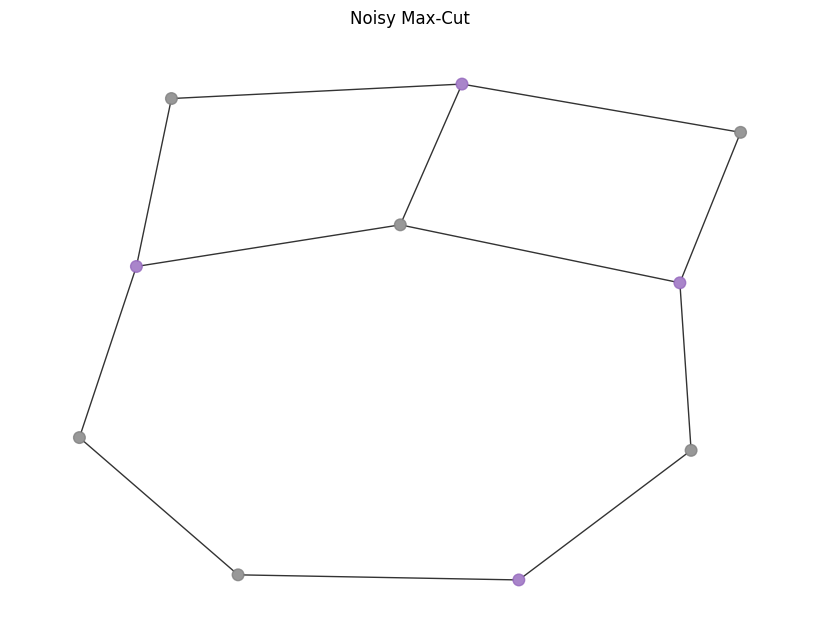

In [69]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring, "Noiseless Max-Cut")
plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

## depth = 3

In [78]:
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from typing import Sequence

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator, Sampler

from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator, Sampler
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms.utils import algorithm_globals
from qiskit import transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

algorithm_globals.random_seed = 42

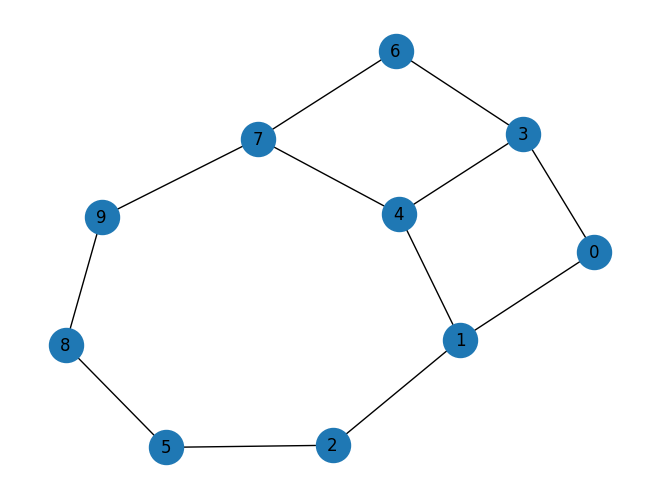

In [79]:
import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph

n = 10
graph = rx.PyGraph()
graph.add_nodes_from(np.arange(n))

edge_list = [
    (0, 1, 1.0),
    (0, 3, 1.0),
    (1, 2, 1.0),
    (1, 4, 1.0),
    (2, 5, 1.0),
    (3, 4, 1.0),
    (3, 6, 1.0),
    (4, 7, 1.0),
    (5, 8, 1.0),
    (6, 7, 1.0),
    (7, 9, 1.0),
    (8, 9, 1.0),
]

graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [80]:
def build_max_cut_paulis(graph: rx.PyGraph):
    pauli_list = []
    for edge in graph.edge_list():
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:\n", cost_hamiltonian)

Cost Function Hamiltonian:
 SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIZIIZ', 'IIIIIIIZZI', 'IIIIIZIIZI', 'IIIIZIIZII', 'IIIIIZZIII', 'IIIZIIZIII', 'IIZIIZIIII', 'IZIIZIIIII', 'IIZZIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


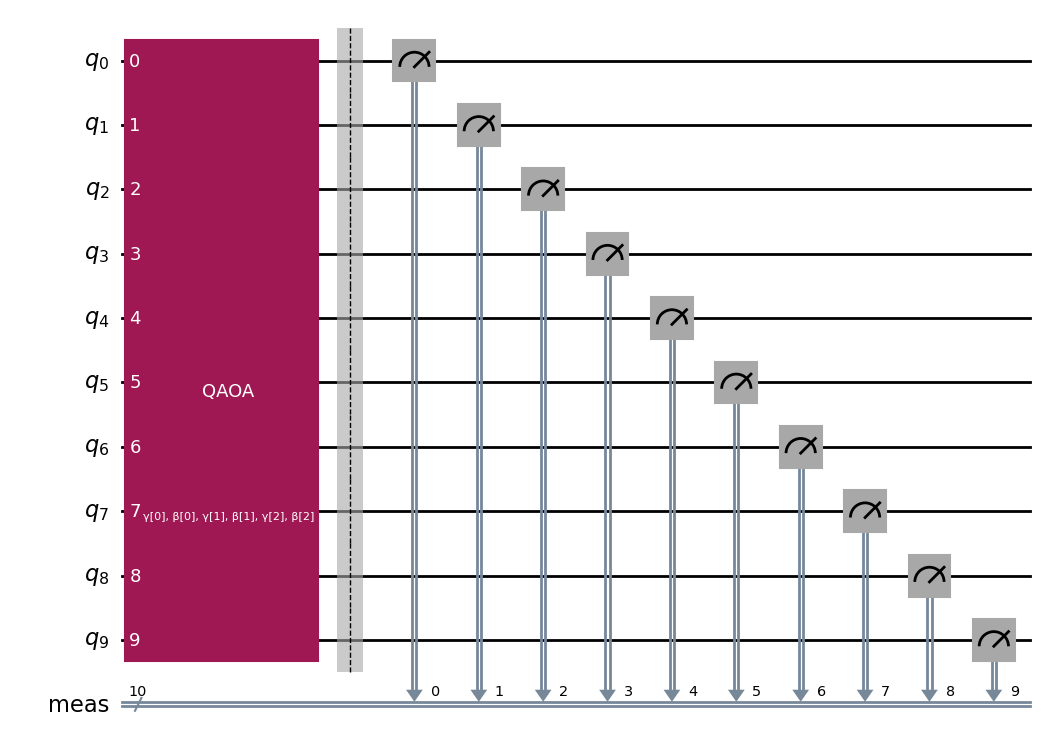

In [81]:
p = 3
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=p)
circuit.measure_all()
circuit.draw(output="mpl")

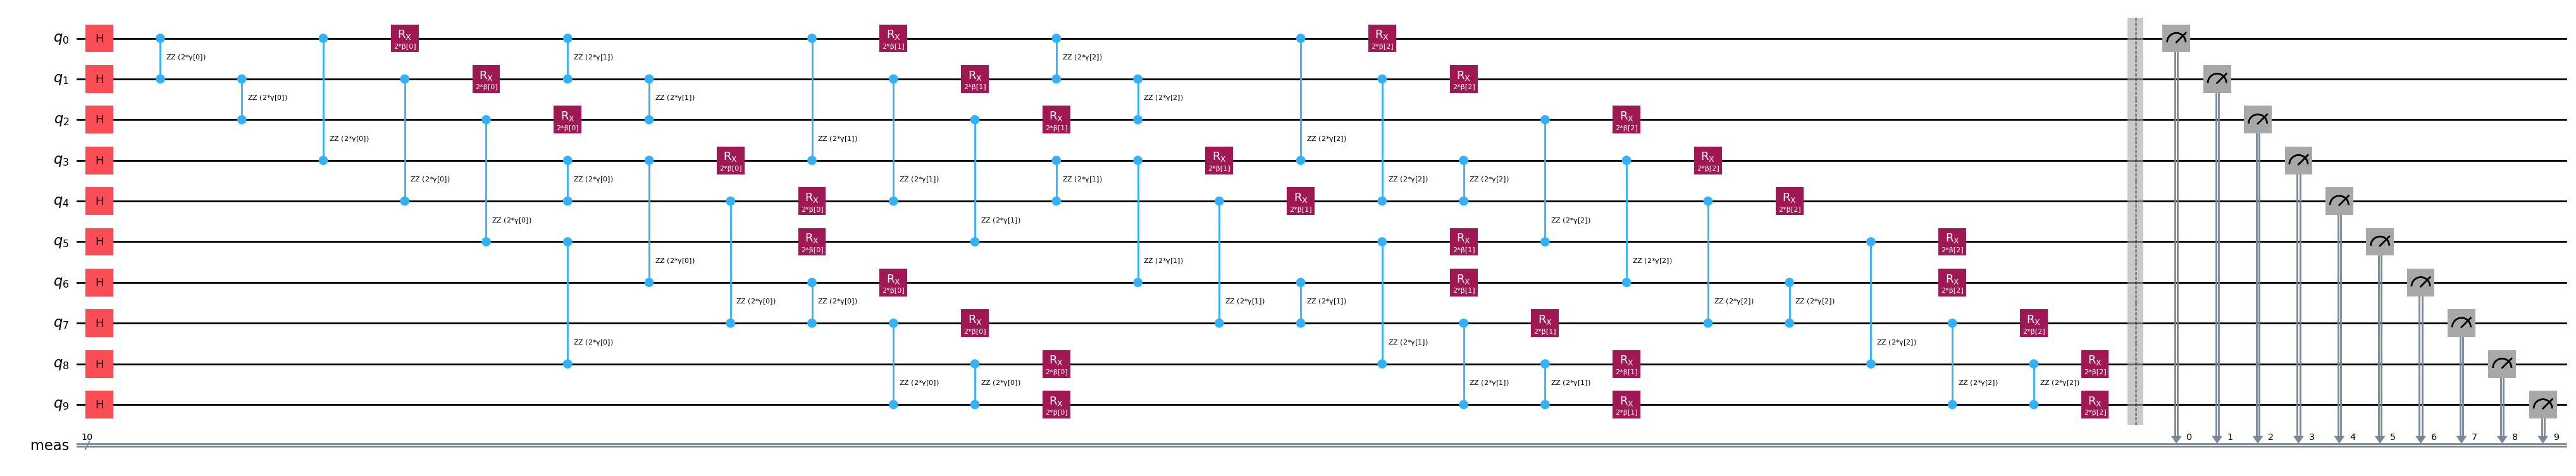

In [82]:
# Backend
backend = AerSimulator()

# Transpile
pass_manager = generate_preset_pass_manager(3)
candidate_circuit = pass_manager.run(circuit)
candidate_circuit = transpile(candidate_circuit, backend, optimization_level=3)

candidate_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [83]:
# Initial params
init_params = [np.pi / 2] * 6
# Define Estimators
estimator_noiseless = Estimator()

# Create Noise Model (2% depolarizing on CX)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 2), ["cx"]
)

# Correct usage for noisy AerSimulator primitive
estimator_noisy = Estimator(run_options={"noise_model": noise_model})

# Objective functions
objective_func_vals = []
objective_func_vals_noisy = []

# def qaoa_objective(params, estimator):
#     job = estimator.run(
#         circuits=[circuit],
#         observables=[cost_hamiltonian],
#         parameter_values=[params]
#     )
#     result = job.result()
#     value = float(result.values[0])

#     if estimator is estimator_noiseless:
#         objective_func_vals.append(value)
#     else:
#         objective_func_vals_noisy.append(value)

#     return value

# # Optimize
# result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")
# result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

def qaoa_objective(params, estimator):
    job = estimator.run(
        circuits=[circuit],
        observables=[cost_hamiltonian],
        parameter_values=[params]
    )
    result = job.result()
    value = float(result.values[0])

    if estimator is estimator_noiseless:
        objective_func_vals.append(value)
        print(f"[Noiseless] Params: {params}, Cost: {value}")
    else:
        objective_func_vals_noisy.append(value)
        print(f"[Noisy] Params: {params}, Cost: {value}")

    return value

# --- Step 4: Run Optimization ---
print("🔧 Optimizing Noiseless QAOA...")
result = minimize(qaoa_objective, init_params, args=(estimator_noiseless,), method="COBYLA")

print("\n🔧 Optimizing Noisy QAOA...")
result_noisy = minimize(qaoa_objective, init_params, args=(estimator_noisy,), method="COBYLA")

# --- Step 5: Print Final Results ---
print("\n✅ Final Noiseless Cost:", result.fun)
print("✅ Final Noisy Cost:", result_noisy.fun)

🔧 Optimizing Noiseless QAOA...
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.107421875
[Noiseless] Params: [2.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.046875
[Noiseless] Params: [1.57079633 2.57079633 1.57079633 1.57079633 1.57079633 1.57079633], Cost: -0.05859375
[Noiseless] Params: [1.57079633 1.57079633 2.57079633 1.57079633 1.57079633 1.57079633], Cost: 0.107421875
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 2.57079633 1.57079633 1.57079633], Cost: 0.193359375
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 2.57079633 1.57079633], Cost: 0.126953125
[Noiseless] Params: [1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 2.57079633], Cost: 0.033203125
[Noiseless] Params: [1.25420311 1.4706086  1.12997033 0.95363993 1.08989524 1.28225567], Cost: -1.865234375
[Noiseless] Params: [ 1.18965161  1.45018091  1.04008849 -0.03340694  0.99184233  1.22342393], Cost: -0.62890625
[

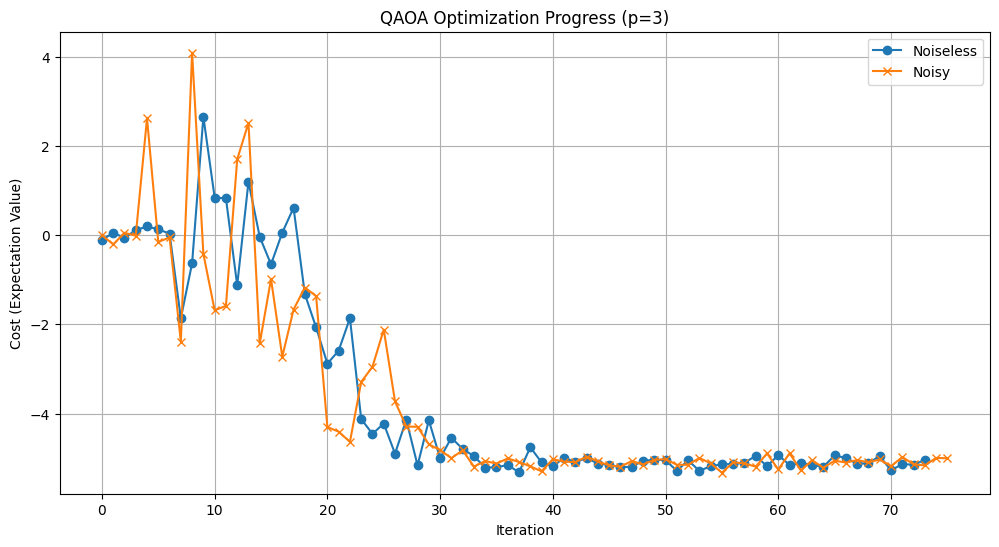

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals, marker='o', label="Noiseless")
plt.plot(objective_func_vals_noisy, marker='x', label="Noisy")
plt.xlabel("Iteration")
plt.ylabel("Cost (Expectation Value)")
plt.title(f"QAOA Optimization Progress (p={p})")
plt.grid(True)
plt.legend()
plt.show()

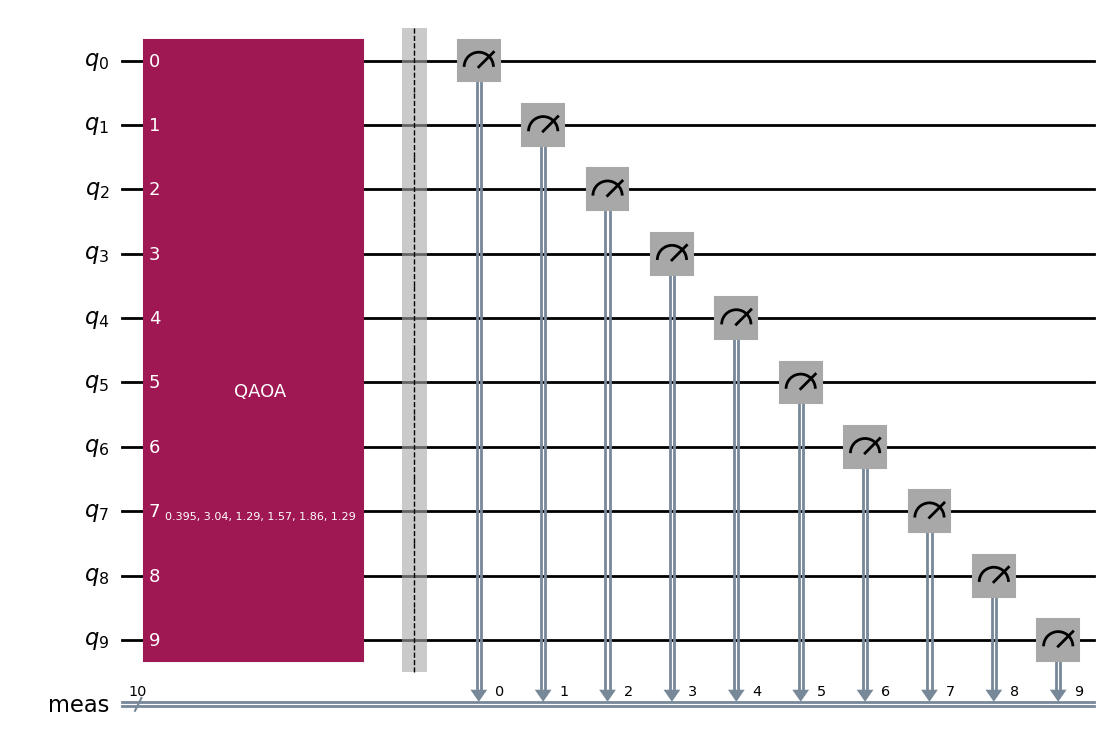

In [85]:
optimized_circuit = circuit.assign_parameters(result.x)
optimized_circuit_noisy = circuit.assign_parameters(result_noisy.x)
optimized_circuit_noisy.draw(output="mpl", fold=False, idle_wires=False)

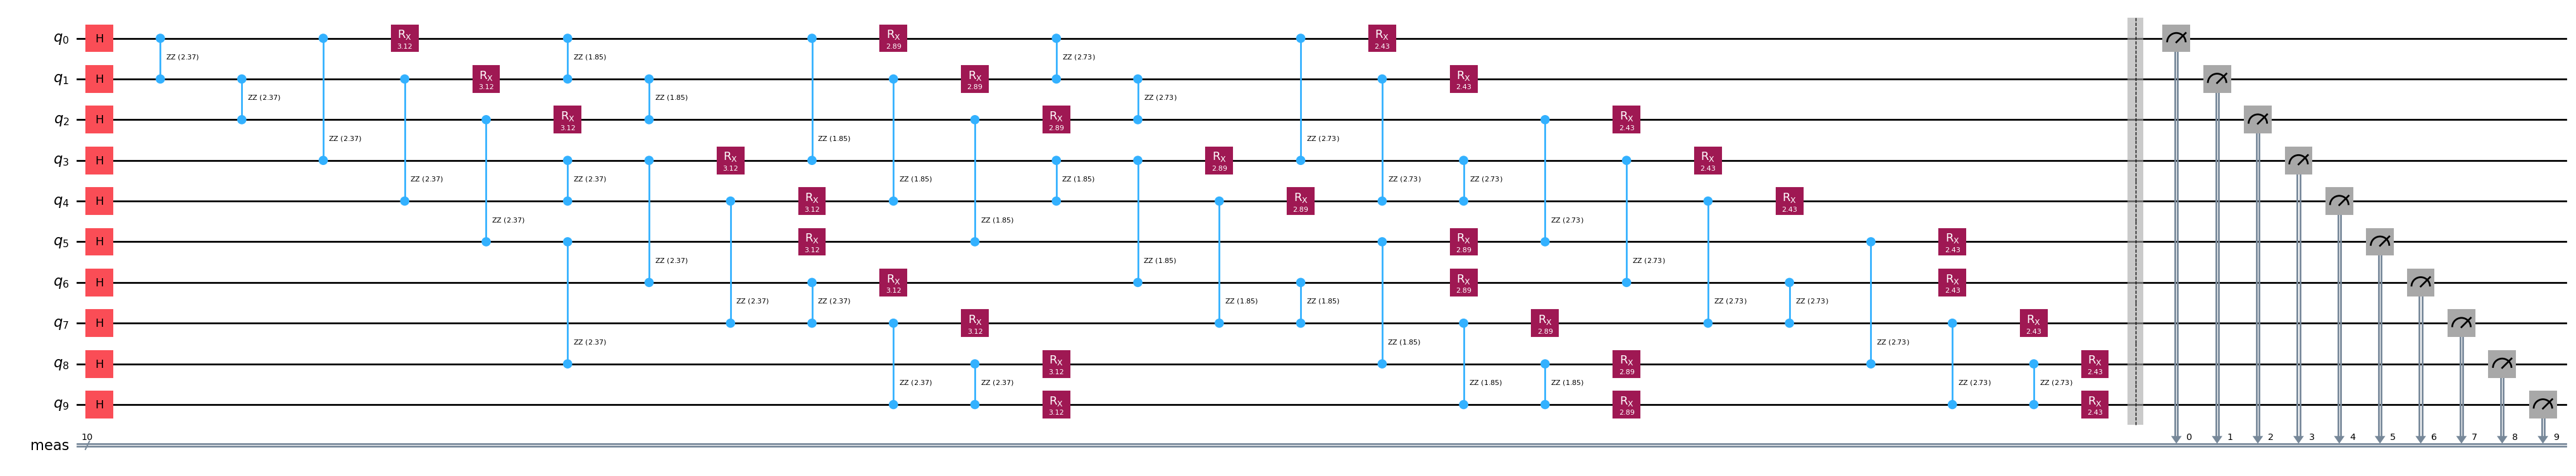

In [86]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw(output="mpl", fold=False, idle_wires=False)

In [87]:
# Run samplers
sampler = Sampler()
sampler_noisy = Sampler(run_options={"noise_model": noise_model})

job = sampler.run([optimized_circuit], shots=10000)
result = job.result()
quasi_dist = result.quasi_dists[0]

job_noisy = sampler_noisy.run([optimized_circuit_noisy], shots=10000)
result_noisy = job_noisy.result()
quasi_dist_noisy = result_noisy.quasi_dists[0]

In [88]:
# Convert to bitstrings
def to_bitstring(integer, num_bits):
    return [int(d) for d in np.binary_repr(integer, width=num_bits)]

def process_distribution(dist):
    final_dist = {}
    for k, v in dist.items():
        if isinstance(k, str):
            final_dist[int(k, 2)] = float(v)
        else:
            final_dist[k] = float(v)
    return final_dist

final_dist = process_distribution(quasi_dist)
final_dist_noisy = process_distribution(quasi_dist_noisy)

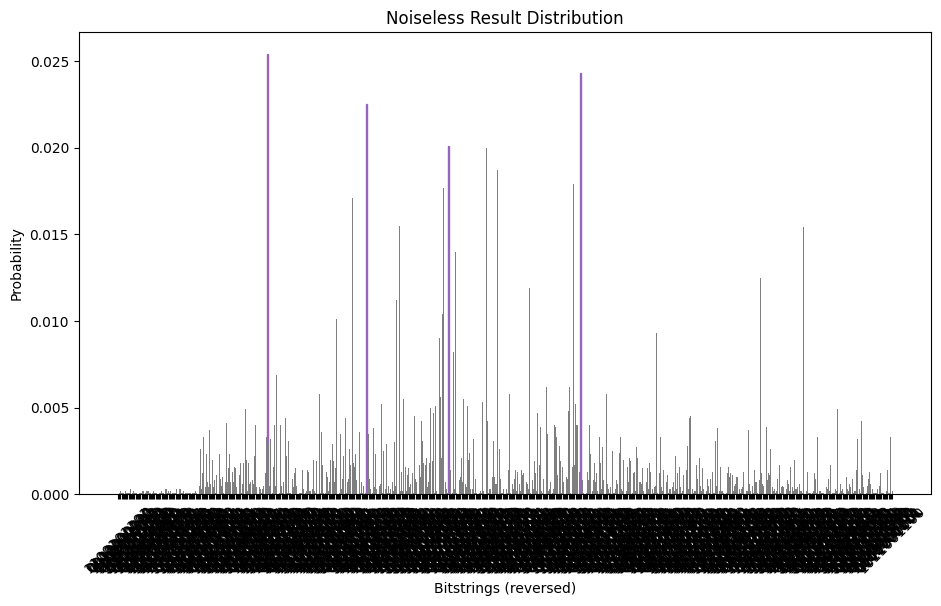

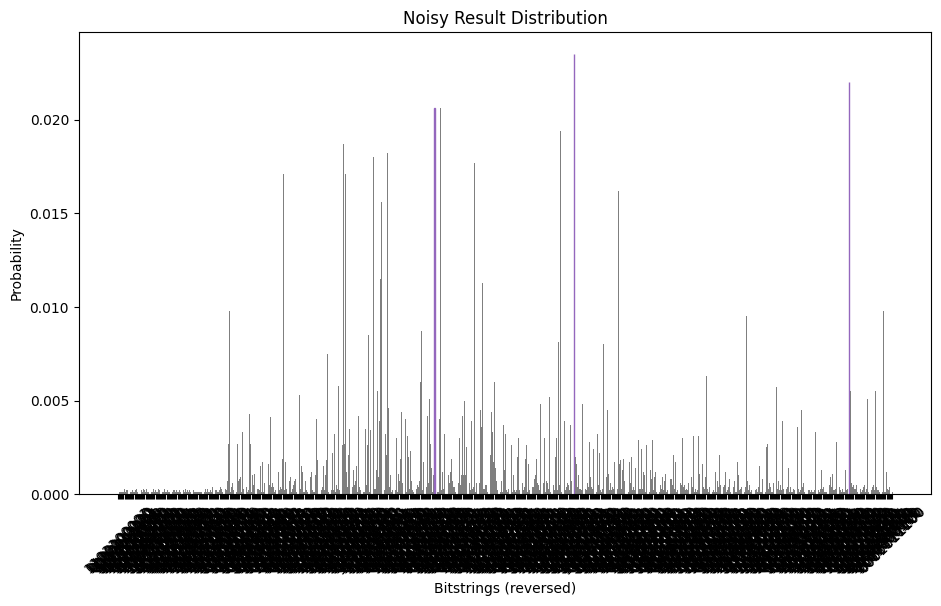

Noiseless bitstring: [0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Noisy bitstring: [1, 0, 0, 0, 1, 1, 1, 0, 0, 1]


In [89]:
# Plotting function
def plot_distribution(final_dist, title):
    keys = list(final_dist.keys())
    values = list(final_dist.values())
    bitstring_labels = [''.join(map(str, to_bitstring(k, n)[::-1])) for k in keys]
    top_4_values = sorted(values, reverse=True)[:4]
    positions = [np.where(np.isclose(values, v))[0][0] for v in top_4_values]

    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(bitstring_labels, values, color="tab:grey")
    for p in positions:
        ax.get_children()[p].set_color("tab:purple")
    plt.show()

plot_distribution(final_dist, "Noiseless Result Distribution")
plot_distribution(final_dist_noisy, "Noisy Result Distribution")

# Most likely result
most_likely = max(final_dist.items(), key=lambda x: x[1])[0]
most_likely_noisy = max(final_dist_noisy.items(), key=lambda x: x[1])[0]

most_likely_bitstring = to_bitstring(most_likely, n)[::-1]
most_likely_bitstring_noisy = to_bitstring(most_likely_noisy, n)[::-1]

print("Noiseless bitstring:", most_likely_bitstring)
print("Noisy bitstring:", most_likely_bitstring_noisy)

Cut value (noiseless): 11
Cut value (noisy): 11


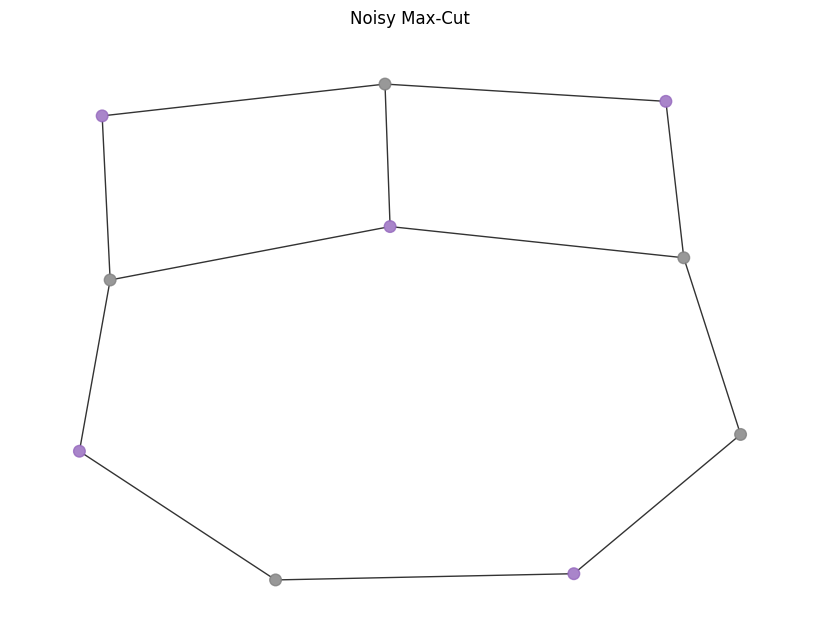

In [90]:
def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    return sum(
        x[u] * (1 - x[v]) + x[v] * (1 - x[u])
        for u, v in graph.edge_list()
    )

cut_val = evaluate_sample(most_likely_bitstring, graph)
cut_val_noisy = evaluate_sample(most_likely_bitstring_noisy, graph)
print("Cut value (noiseless):", cut_val)
print("Cut value (noisy):", cut_val_noisy)

def plot_result(G, x, title):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]
    pos = rx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    rx.visualization.mpl_draw(G, node_color=colors, node_size=70, alpha=0.8, pos=pos)
    plt.title(title)
    plt.show()

plot_result(graph, most_likely_bitstring_noisy, "Noisy Max-Cut")

# Node 20

# https://colab.research.google.com/drive/1PgiyP30DJSULtHc2uWzcdb2e2ivmMZqH?usp=sharing

# Final-version: https://colab.research.google.com/drive/1ThNAurGjjRtiC6jpqP_yTisECTAJQraW?usp=sharing

# Comparision:
# https://colab.research.google.com/drive/1T0rB5viLQQToJmINsmMWg37aMUSito0V?usp=sharing